# Lab 2: Classification
## AirBnB Listings for Los Angeles Area
### Jason McDonald, Miguel Bonilla, Zachary Bunn

**Table of Contents**

- [Data Preparation: Part 1](#Data-Preparation:-Part-1)
    - [Data Types and Descriptions](#Data-Types-and-Descriptions)
    - [Data Wrangling](#Data-Wrangling)
    - [Label and One-Hot Encoding](#Label-and-One-Hot-encoding)
    - [Scaling numerical varialbes](#Scaling-numerical-variables)
- [Data Preparation: Part 2](#Data-Preparation:-Part-2)
- [Modeling and Evaulation 1](#Modeling-and-Evaluation-1)
- [Modeling and Evaulation 2](#Modeling-and-Evaluation-2)
- [Modeling and Evaulation 3](#Modeling-and-Evaluation-3)
    - [Task 1: Regression](#Task-1:-Regression)
        - [Elastic Net](#Elastic-Net)
        - [Lasso Regression](#Lasso-Regression)
        - [Random Forest Regressor](#Random-Forest-Regressor)
        - [SVR](#SVR)
        - [SGD Regression](#SGD-Regression)
    - [Task 2: Classification](#Task-2:-Classification)
        - [Random Forest](#Random-Forest)
        - [NaiveBayes](#NaiveBayes)
        - [SVC](#SVC)
        - [Logistic Regression](#Logistic-Regression)
        - [KNN](#KNN)
- [Modeling and Evaulation 4](#Modeling-and-Evaluation-4)
- [Modeling and Evaulation 5](#Modeling-and-Evaluation-5)
- [Modeling and Evaulation 6](#Modeling-and-Evaluation-6)
- [Deployment](#Deployment)
- [Exceptional Work](#Exceptional-Work)

### Data Preparation: Part 1
Rubric (10 pts): Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

#### Data Wrangling
First of all, we will clean up the data, imputing missing values as done from previous work

#### Data Types and Descriptions

| Field | Type | Description | Scale |
| :--- | :---: | :---: | :--- |
| id | integer | Airbnb's unique identifier for the listing | 42041 Unique Identifiers|
| name | text | Name of the listing | NA|
| host_id | integer | Airbnb's unique identifier for the host/user | Less than id since a host can have multiple listings|
| host_name | text | Name of the host. Usually just the first name(s).| NA|
| host_since | date | The date the host/user was created. For hosts that are Airbnb guests this could be the date they registered as a guest.| NA|
| host_location | text | The host's self reported location| NA|
| host_is_superhost | boolean | If host has Superhost classification. These are highly rated hosts.| NA|
| host_total_listings_count | text | The number of listings the host has (per Airbnb calculations)| 0 to 3322|
| host_identity_verified | boolean | The Host has verified their identity| NA| 
| neighbourhood_cleansed | text | The neighbourhood as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles.| NA|
| latitude | numeric | Uses the World Geodetic System (WGS84) projection for latitude and longitude. | Any latitudinal value|
| longitude | numeric | Uses the World Geodetic System (WGS84) projection for latitude and longitude. | Any longitudinal value|
| property_type | text | Self selected property type. Hotels and Bed and Breakfasts are described as such by their hosts in this field | NA|
|room_type | text | [Entire home/apt\Private room\Shared room\Hotel] All homes are grouped into the following three room types: Entire place, Private access to the entire home, Private rooms - Your own room in a shared house, Shared rooms - shared bedrooms and common rooms with other guests. | 5 Types of Rooms|
| accommodates | integer | The maximum capacity of the listing | 0 to 16 guests|
| bathrooms_text | string | The number of bathrooms in the listing. On the Airbnb web-site, the bathrooms field has evolved from a number to a textual description. For older scrapes, bathrooms is used. | anywhere from 0 - 8 counting half-baths|
|bedrooms | integer | The number of bedrooms | 0 to 24 bedrooms|
| beds | integer | The number of bed(s) | 0 - 34 beds|
| amenities | json | Array of added features that the host wanted to include as a listed benefit| Differs from listing to listing|
| price | currency | daily price in local currency | Avg of 0 to 25,000 dollars with an outlier at 100k|
| has_availability | boolean [t=true; f=false] | if the listing is available or not | NA|
| calendar_last_scraped | date | Last calendar date the data was scraped | NA|
| number_of_reviews | integer | The number of reviews the listing has | 0 to 1512|
| review_scores_rating | float | Score of property | 0.0 to 5.0 avgeraged scale|
| instant_bookable | boolean[t=true; f=false] | Whether the guest can automatically book the listing without the host requiring to accept their booking request. An indicator of a commercial listing. | NA|


In [28]:
# import packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearnex import patch_sklearn
from turtle import title
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from math import sqrt
import time



In [2]:
#read in the data ditionary and display the descriptions

dataDict = pd.read_csv('Data_Files/DataDictionary.txt', "|")
dataDict = dataDict.iloc[:, 1:5]
ddFig = go.Figure(data=[go.Table(columnorder = [0,1,2,3],columnwidth = [80,100,500,250],header=dict(values=dataDict.columns.tolist(), fill_color = '#00A699', align='left',line_color='darkslategray',font=dict(color='white', size=12), height=40),
                                             cells = dict(values=dataDict.T, fill_color = [['#a9a9a9', '#ffffff']*len(dataDict)],line_color='darkslategray', align='left')
                                             )])


ddFig.show()

C:\Users\jason\AppData\Local\Temp\ipykernel_4644\1221398388.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  dataDict = pd.read_csv('Data_Files/DataDictionary.txt', "|")


In [3]:
#read in the data
#df = pd.read_csv("https://media.githubusercontent.com/media/boneeyah/DS7331_Group/main/Data_Files/airbnb_los_angeles.csv")
df = pd.read_csv("Data_Files/airbnb_los_angeles.csv")

In [4]:
#define a function that will be used to print out performance of the models
def plotMetrics(score, cellTitle):
    fig = ff.create_table(score, height_constant=20, colorscale=[[0, '#00A699'], [.5, '#a9a9a9'], [1, '#ffffff']])

    Metrics = ['Mean Accuracy', 'Mean Recall', 'Mean Precision']
    MeanScores = [score['accuracy'].mean(), score['recall'].mean(), score['precision'].mean()]

    fig.add_trace(go.Bar(x=Metrics, y=MeanScores, xaxis='x2', yaxis='y2', marker = dict(color='#FC642D'), width=.25))
    fig.update_layout(title_text=cellTitle,
                        height = 800, margin = {'t':75, 'l':50}, yaxis = {'domain': [0, .45]}, xaxis2 = {'anchor': 'y2'}, 
                        yaxis2 = {'domain': [.6, 1], 'anchor': 'x2', 'title': 'Score'})
    return fig

In [5]:
# Removing variables which will not be useful for the classification analysis
for col in [
    'listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_url','host_about','host_response_time','host_response_rate','host_acceptance_rate',
    'host_thumbnail_url','host_picture_url','host_verifications','host_has_profile_pic','bathroom_text','host_listings_count','host_neighbourhood','bathrooms','minimum_minimum_nights',
    'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','availability_30','availability_60',
    'availability_90','availability_365','calendar_last_scraped','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_accuracy','review_scores_communication','review_scores_cleanliness',
    'review_scores_checkin','review_scores_value','review_scores_location','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms','reviews_per_month','neighbourhood','neighbourhood_group_cleansed', 'first_review','last_review','minimum_nights','maximum_nights','license','host_total_listings_count'
]:
    if col in df:
        del df[col]

In [6]:
# remove nulls
df = df[~df.review_scores_rating.isnull() & ~df.bathrooms_text.isnull() & ~df.host_since.isnull() & ~df.host_location.isnull()]

## getting property type from string
types = ['Private room', 'Entire', 'Room in hotel','Room','Shared room']
pat = '|'.join(r"\b{}\b".format(x) for x in types)

df['property_type']= df['property_type'].str.extract('('+ pat + ')', expand = False)
df['property_type'] = (df.property_type.
                       fillna(value = 'other').
                       replace(['Entire','Room in hotel'],['Entire unit','Hotel room']))
df['property_type'].value_counts()

Entire unit     22767
Private room     8081
Shared room       510
Room              401
other             298
Hotel room        272
Name: property_type, dtype: int64

In [7]:
# impute values based on median
df['beds'] = df[['accommodates','beds']].groupby(by = 'accommodates').transform(lambda grp: grp.fillna(grp.median()))
df_grouped = df.groupby(by = ['property_type','beds'])
df_imputed = df_grouped[['beds','bedrooms']].transform(lambda grp: grp.fillna(grp.median()))

index = df_imputed[df_imputed.bedrooms.isnull()].index
df = df.drop(index= index)

df['imputed']=df_imputed[['bedrooms']]

# replace 'bedrooms' column with imputed column and deleting the duplicated column
df['bedrooms'] = df['imputed']
del df['imputed']

In [8]:
## fixing variable types
df['host_since'] = pd.to_datetime(df.host_since)
df['price'] = df['price'].replace('[\$,]','',regex = True).astype(float)
df['bathrooms_text'] = df['bathrooms_text'].replace(['Half-bath', 'Shared half-bath', 'Private half-bath'],['0.5 bath','0.5 shared bath', '0.5 private bath'])
df_bathrooms = df['bathrooms_text'].str.split(n=1, expand=True).rename(columns = {0:'bathroom_number',1:'bathroom_type'})
df_bathrooms['bathroom_type'] = df_bathrooms.bathroom_type.fillna(value = 'bath')
df_bathrooms['bathroom_type'] = df_bathrooms['bathroom_type'].replace(['baths','shared baths'],['bath','shared bath'])
df_bathrooms['bathroom_number'] = df_bathrooms['bathroom_number'].astype('float')
df.insert(15, 'bathroom_number',df_bathrooms['bathroom_number'])
df.insert(16, 'bathroom_type', df_bathrooms['bathroom_type'])
del df['bathrooms_text']

In [9]:
### filter out price outliers
df = df[(df.beds<10) & (df.price<750)]
df = df.reset_index(drop=True)

In [10]:
# breakdown of categorical variables with number of levels (unique)
df.iloc[:,[1,3,5,6,7,8,11,12,15,18,20,23]].describe().T

,count,unique,top,freq
name,30580,29942,Boutique Hostel,46
host_name,30580,6604,David,249
host_location,30580,980,"Los Angeles, California, United States",10613
host_is_superhost,30580,2,f,20236
host_identity_verified,30580,2,t,26080
neighbourhood_cleansed,30580,302,Long Beach,1163
property_type,30580,6,Entire unit,21090
room_type,30580,4,Entire home/apt,21433
bathroom_type,30580,3,bath,22738
amenities,30580,28937,"[""Hangers"", ""First aid kit"", ""Heating"", ""Fire ...",40


This table shows the number of unique levels for categorical variables in our dataset, as well as the most common level of each variable along with its frequency count. From this table, we can see that about 1/3 of listings (10613/30580) correspond to a host who has Superhost status. Additionally the table shows that amenities has 28937 unique levels, given the way these are listed for each listing, a decission was made to drop the variable for this project.

#### Label and One-Hot encoding
To be able to use categorical variables when fitting our models, we will first encode these variables using LabelEncoder and OneHotEncoder, which convert variables into categorical variables represented by binary values of 0 and 1. LabelEncoder can be used to convert binary categories into binary values of 0 and 1 for each level of the original variable. OneHotEncoder can be used to covert variables with more than two categorical variables, by creating n-1 columns (where n corresponds to the number of levels in a category).

In [11]:
# Model will focus on classifying superhost status
# since we're encoding with binary response, we can use labelencoder from sklearn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['host_is_superhost'] = label_encoder.fit_transform(df['host_is_superhost'])
print('host_is_superhost')
df.host_is_superhost.value_counts()

host_is_superhost


0    20236
1    10344
Name: host_is_superhost, dtype: int64

The value of 0 corresponds to the status of 'f' of the original variable, a quick check shows that the value matches that which was previously found (20236 for 'f').

In [12]:
## encoding binary categorical variables
# encode identity verified
df['host_identity_verified'] = label_encoder.fit_transform(df['host_identity_verified'])
print('host_identity_verified')
print(df.host_identity_verified.value_counts())

#encode has_availability
df['has_availability'] = label_encoder.fit_transform(df['has_availability'])
print('has_availability')
print(df.has_availability.value_counts())

#encode instant bookable
df['instant_bookable'] = label_encoder.fit_transform(df['instant_bookable'])
print('instant_bookable')
print(df.instant_bookable.value_counts())

host_identity_verified
1    26080
0     4500
Name: host_identity_verified, dtype: int64
has_availability
1    28785
0     1795
Name: has_availability, dtype: int64
instant_bookable
0    19767
1    10813
Name: instant_bookable, dtype: int64


In [13]:
### new feature host_is_local, from host_location. Binary variable of whether host lives in greater LA area or not.
#los_angeles = pd.read_csv('Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = pd.read_csv('https://raw.githubusercontent.com/boneeyah/DS7331_Group/main/Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = los_angeles.iloc[:,0].tolist()

pattern = '|'.join(los_angeles)
df['host_is_local'] = df['host_location'].str.contains(pattern)

df['host_is_local'] = label_encoder.fit_transform(df['host_is_local'])
print('host_is_local')
df.host_is_local.value_counts()

host_is_local


0    19056
1    11524
Name: host_is_local, dtype: int64

With the newly created variable host_is_local replacing host_location, we now have a variable with 2 levels, as opposed to the original with over 900 categories.

To convert host_since from datetime to a useable format, we made the decission to create a new variable, host_for, corresponding to the number of months since the host first listed properties on AirBnB. This was accomplished by subtracting the host_since date from the date on which the data was pulled from AirBnB (06-06-2022).

In [14]:
## new feature host_for, a numerical variable that corresponds to length in months since becoming host
## data is from June 6 2022, 06-06-2022
end_date = pd.to_datetime('06-06-2022', format= "%m-%d-%Y")
df['host_for'] = (end_date-df.host_since)/np.timedelta64(1,'M')

df = df.drop(columns= ['host_location', 'host_since']) #drop old host_location and host_since columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              30580 non-null  int64  
 1   name                            30580 non-null  object 
 2   host_id                         30580 non-null  int64  
 3   host_name                       30580 non-null  object 
 4   host_is_superhost               30580 non-null  int32  
 5   host_identity_verified          30580 non-null  int32  
 6   neighbourhood_cleansed          30580 non-null  object 
 7   latitude                        30580 non-null  float64
 8   longitude                       30580 non-null  float64
 9   property_type                   30580 non-null  object 
 10  room_type                       30580 non-null  object 
 11  accommodates                    30580 non-null  int64  
 12  bathroom_number                 

This table shows the remaining variables which need to be One-Hot Encoded (neighbourhood_cleansed, property_type, room_type, bathroom_type) or dropped since they won't be useful for our modeling (name, host_name, amenities, id, host_id.

In [15]:
# One Hot Encoding other categorical variables as a non-sparse dataframe
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

df_temp = df[['id','neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']] # to get only the cat variables


In [16]:
ohe = OneHotEncoder(drop='first',sparse=True)
feature_arr = ohe.fit_transform(df_temp[['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']])
feature_labels = ohe.get_feature_names_out()

#create dataframe with features
df_temp = pd.DataFrame.sparse.from_spmatrix(feature_arr,columns=feature_labels)

In [17]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 311 entries, neighbourhood_cleansed_Adams-Normandie to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311)
memory usage: 668.7 KB


In [18]:
# drop original columns and join with new onehotencoded columns
df = df.drop(columns = ['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type','amenities','name','host_name','id','host_id','latitude','longitude']).join(df_temp)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 325 entries, host_is_superhost to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311), float64(6), int32(4), int64(4)
memory usage: 3.5 MB


#### Scaling numerical variables
We will rescale our predictors using StandardScaler to ensure all variables are on the same scale so that variable importance is not influenced by the range of values of a variable

In [19]:
from sklearn.preprocessing import StandardScaler

y_reg = df.loc[:,df.columns == 'price'] ### saving original price prior to scaling for regression modeling 
num_columns = ['accommodates','bathroom_number','bedrooms','beds','price','number_of_reviews','review_scores_rating','calculated_host_listings_count','host_for']
scaled = df[num_columns]
scaled = pd.DataFrame(StandardScaler().fit_transform(scaled),columns=scaled.columns)

df[num_columns] = scaled[num_columns]

In [20]:
### clean up temporary files
del df_temp, feature_arr, feature_labels, scaled
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 325 entries, host_is_superhost to bathroom_type_shared bath
dtypes: Sparse[float64, 0](311), float64(9), int32(4), int64(1)
memory usage: 3.5 MB


In [21]:
df[num_columns].describe()

,accommodates,bathroom_number,bedrooms,beds,price,number_of_reviews,review_scores_rating,calculated_host_listings_count,host_for
count,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04,3.058000e+04
mean,-8.922446e-17,-5.204760e-17,4.461223e-17,2.974149e-17,2.974149e-17,-1.115306e-17,-7.435372e-18,2.230612e-17,-1.487074e-17
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,-1.107019e+00,-1.783036e+00,-6.610494e-01,-7.509706e-01,-1.243972e+00,-5.770197e-01,-7.623051e+00,-2.716875e-01,-2.069410e+00
25%,-7.045577e-01,-5.371434e-01,-6.610494e-01,-7.509706e-01,-7.143722e-01,-5.400700e-01,-4.401467e-02,-2.716875e-01,-7.273150e-01
50%,-3.020962e-01,-5.371434e-01,-6.610494e-01,-5.794827e-02,-3.259995e-01,-4.045877e-01,2.805693e-01,-2.495258e-01,6.657625e-02
75%,5.028269e-01,7.087490e-01,4.115008e-01,6.350741e-01,4.154395e-01,8.807517e-02,4.915489e-01,-1.387172e-01,7.201097e-01
max,4.929904e+00,1.254473e+01,6.846802e+00,4.793208e+00,3.974347e+00,1.803332e+01,4.915489e-01,1.149618e+01,2.918804e+00


## Data Preparation: Part 2
Rubric  (5 pts): Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [22]:
## complete column information for the 325 columns in our dataset
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 325 columns):
 #    Column                                                        Dtype             
---   ------                                                        -----             
 0    host_is_superhost                                             int32             
 1    host_identity_verified                                        int32             
 2    accommodates                                                  float64           
 3    bathroom_number                                               float64           
 4    bedrooms                                                      float64           
 5    beds                                                          float64           
 6    price                                                         float64           
 7    has_availability                                              int32             
 8    number_of_revi

variables:

- host_is_superhost - categorical variable of whether host is a super host (1) or not (0) (label encoded)
- host_identity_verified - categorical variable of whether host identifity has been verified (1) or not (0) (label encoded)
- neighbourhood_cleansed - neighborhorhood on which the listing is located at (One-Hot encoded)
- property_type - category type of listed property (one hot encoded)
- room_type - category type of room(s) of listed property (one hot encoded)
- accommodates - numerical feature of maximum number of guests that can stay at a listing
- bathroom_number - new feature (from bathroom text), for number of bathrooms present at a listing
- bathroom_type - new feature (from bathroom text) for category type of bathroom(s) at a listing (one hot encoded)
- bedrooms - numerical feature of number of bedrooms on the listed property
- beds - numerical variable of number of beds on the listed property
- price - the average daily rate to rent the listed property
- has_availability - categorical variable of whether property is available (1) or not (0) (label encoded)
- number_of_reviews - numerical variable of number of times the property has been reviewed
- review_scores_rating - numerical variable for the review score of the property (from 0-5)
- instant_bookable - categorical variable of whether guest can book the listing automatically (1) or needs to be approved by host first (0) (label encoded)
- calculated_host_listings_count - numerical variable of the total number of listings owned by the property's owner.
- host_is_local - new feature (created from host_location), for whether the property host is local to the greater LA area (1) or not local (0) (label encoded)
- host_for - new feature (created from host_since), for how long (in months) since the host first became an AirBnB host

The final dataset to be used for classification and regression modeling includes numerical variables which have all been scaled (standardized by centering over the mean and scaling over the st. dev), as well as categorical variables which have been encoded as 0s and 1s using label encoding and One-Hot encoding. Our final dataset consists of 30580 entries (AirBnB listed properties in LA), with 18 features (9 categorical variables and 9 numerical variables) represented by 325 columns on a sparse dataframe format.

## Modeling and Evaluation 1
Rubric (10 pts): Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

In [23]:
### sensitivity (recall) since we want to have a model that does a better job at predicting host is superhost when host is indeed a superhost
### for modeling eval part 4 we will use ROC (return of characteristic) as visual support

For our the goal of our test on finding the best rates for each neighborhood in Los Angeles we are focusing on using RMSE for regression and Adjusted R2 as the secondary metric. The RMSE is vital since it’s a scale of the response variable, meaning it translates as the error (or difference) in US Dollars off of the target value. The Adjusted R2 functions similar to RMSE but instead of the error will measure the accuracy of our model. It’s secondary since the exact error is a direct measurement whereas Adjusted R2 is an optimistic estimate of fit. Sensitivity will be used for our main classification metric. It will assist in determining the robustness of our models. Due to the size of variables we have it assess the efficacy of each model to address the influence of each variable.

## Modeling and Evaluation 2
Rubric (10 pts): Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

For task 1, we will be using 10-fold cross validation as this method is better suited for fitting models that will focus on prediction. Utilizing a standard random split has the disadvantage that the models performance is heavily reliant on the random test-train split produced, which can lead to more biased models. 10-fold cross validation can help mitigate this by utilizing 10 different train-test splits, effectively allowing us to test our models on multiple test sets and producing results that will better reflect the model's true performance when predicting test data. Since our goal is to focus on predicting price, and comparing different sets of models in terms of their results, we determined 10-fold cross validation was the ideal approach.

For classification methods, Stratified K-fold cross validation, is an extension of cross validation that works better for datasets where the response variable is imbalanced. With imbalanced responses, individual folds could end up being unrepresentative of the original distribution, with test splits that could randomly contain lopsided response counts. Stratified cross validation helps mitigates this issue by creating folds that are more representative of the original distributions. Therefore, we will first look into whether our response variable (host_is_superhost) is close to 50-50 or if it sufferes from imbalance.

In [24]:
df.host_is_superhost.value_counts()

0    20236
1    10344
Name: host_is_superhost, dtype: int64

We can see that the response variable is imbalanced with 10344/30580 ~ 34% superhost and 20236/30580 ~ 66% not superhost. Therefore we will use stratified 10-fold cross validation, since this methond creates folds that preserve the distribution of each class, making it a better tool for our imbalanced data.

In [25]:
### task 1 (regression)
from sklearn.model_selection import KFold
import scipy

X_reg = df.loc[:,df.columns != 'price']
X_reg = scipy.sparse.coo_matrix(X_reg)
X_reg = X_reg.tocsr()

kf = KFold(n_splits=10,shuffle=True,random_state=1024)

In [26]:
### task 2 (classification)
from sklearn.model_selection import StratifiedKFold

X = df.loc[:,df.columns != 'host_is_superhost']
y = df.loc[:,df.columns == 'host_is_superhost']
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1024) #setting up random seed for reproducibility

#convert X into a sparse martix using scipy
X_mat = scipy.sparse.coo_matrix(X)
X_mat = X_mat.tocsr()

## Modeling and Evaluation 3
Rubric (20 pts): Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

### Task 1: Regression

#### Elastic Net

In [26]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import time
en_reg = ElasticNet(random_state=1024)

enScore=[]
for train,test in kf.split(X_reg,y_reg):
    en_reg.fit(X_reg[train],y_reg.values.ravel()[train])
    y_hat = en_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    enScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
enScore = pd.DataFrame(enScore)
print(enScore)
enScore.mean()

     Adj_R2        RMSE
0  0.409761  103.088881
1  0.408053  104.731626
2  0.395228  100.404140
3  0.427499  101.881303
4  0.410113  105.675174
5  0.410364  101.766770
6  0.421153  103.726412
7  0.421698  102.880609
8  0.416245   98.241600
9  0.409179  103.273867


Adj_R2      0.412929
RMSE      102.567038
dtype: float64

In [27]:
%%time
start =time.time()
## adjust tuning parameters alpha and l1_ratio
en_reg = ElasticNet(random_state=1024,alpha=.001, l1_ratio=.75)

enScore=[]
for train,test in kf.split(X_reg,y_reg):
    en_reg.fit(X_reg[train],y_reg.values.ravel()[train])
    y_hat = en_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    enScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
enScore = pd.DataFrame(enScore)
print(enScore)
enScore.mean()
stop =time.time()
enTime=stop-start

     Adj_R2       RMSE
0  0.551412  89.871427
1  0.582434  87.962823
2  0.556569  85.974321
3  0.559184  89.399533
4  0.561277  91.134720
5  0.549508  88.952294
6  0.578146  88.549967
7  0.578669  87.814807
8  0.566280  84.680751
9  0.569004  88.206198
CPU times: user 16min 5s, sys: 17min 28s, total: 33min 34s
Wall time: 3min 38s


#### Lasso Regression

In [28]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso()
lassoScore = []
for train, test in kf.split(X_reg, y_reg):
    lasso_reg.fit(X_reg[train], y_reg.values.ravel()[train])
    y_hat = lasso_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    lassoScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
lassoScore = pd.DataFrame(lassoScore)
print(lassoScore)
lassoScore.mean()

     Adj_R2        RMSE
0  0.462638   98.362932
1  0.476888   98.454106
2  0.453151   95.474937
3  0.481817   96.927772
4  0.457312  101.359362
5  0.463906   97.036318
6  0.479062   98.401176
7  0.486027   96.989815
8  0.477007   92.988226
9  0.462001   98.549222


Adj_R2     0.469981
RMSE      97.454387
dtype: float64

In [29]:
%%time
start =time.time()
### will repeat with adjusted alpha parameter (only tuning for lasso)
lasso_reg = Lasso(alpha=.2)
lassoScore = []
for train, test in kf.split(X_reg, y_reg):
    lasso_reg.fit(X_reg[train], y_reg.values.ravel()[train])
    y_hat = lasso_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    lassoScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
lassoScore = pd.DataFrame(lassoScore)
print(lassoScore)
lassoScore.mean()
stop = time.time()
lassoTime = stop-start

     Adj_R2       RMSE
0  0.525339  92.446363
1  0.559826  90.312643
2  0.530683  88.448179
3  0.537246  91.597048
4  0.539886  93.330069
5  0.531803  90.683518
6  0.559019  90.535179
7  0.554761  90.271966
8  0.543976  86.830801
9  0.543235  90.804792
CPU times: user 37.7 s, sys: 36.6 s, total: 1min 14s
Wall time: 11.3 s


#### Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(max_depth=3, n_jobs=-1, random_state=1024)

rfScore = []
for train,test in kf.split(X_reg,y_reg):
    rf_reg.fit(X_reg[train],y_reg.values.ravel()[train])
    y_hat = rf_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    rfScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
rfScore = pd.DataFrame(rfScore)
print(rfScore)
rfScore.mean()

     Adj_R2        RMSE
0  0.441388  100.288929
1  0.468958   99.197609
2  0.441773   96.463039
3  0.465543   98.438003
4  0.453662  101.699656
5  0.452194   98.090601
6  0.470352   99.220434
7  0.464558   98.994790
8  0.443142   95.951569
9  0.456293   99.070630


Adj_R2     0.455786
RMSE      98.741526
dtype: float64

In [31]:
%%time
start = time.time()
### will repeat adjusting parameters, increasing max_depth to 15, and reduding estimators to 50 to keep computational cost from increasing too much

rf_reg = RandomForestRegressor(max_depth=15,n_estimators=50, n_jobs=-1, random_state=1024)

rfScore = []
for train,test in kf.split(X_reg,y_reg):
    rf_reg.fit(X_reg[train],y_reg.values.ravel()[train])
    y_hat = rf_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    rfScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
rfScore = pd.DataFrame(rfScore)
print(rfScore)
rfScore.mean()
stop = time.time()
rfTime = stop-start

     Adj_R2       RMSE
0  0.569929  87.997012
1  0.624524  83.411851
2  0.585716  83.100685
3  0.596189  85.564945
4  0.596799  87.367436
5  0.598200  84.007603
6  0.625221  83.463246
7  0.629238  82.376593
8  0.591916  82.140059
9  0.594257  85.583097
CPU times: user 7min 9s, sys: 767 ms, total: 7min 10s
Wall time: 42.5 s


#### SVR

In [32]:
from sklearnex import patch_sklearn,unpatch_sklearn
patch_sklearn()
from sklearn.svm import SVR

svr_reg = SVR()

svrScore = []
for train,test in kf.split(X_reg,y_reg):
    svr_reg.fit(X_reg[train],y_reg.values.ravel()[train])
    y_hat = svr_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    svrScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
svrScore = pd.DataFrame(svrScore)
print(svrScore)
svrScore.mean()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


     Adj_R2        RMSE
0  0.422205  101.996394
1  0.440263  101.842437
2  0.430422   97.438914
3  0.453161   99.571822
4  0.414890  105.246424
5  0.434782   99.637295
6  0.433802  102.586867
7  0.440841  101.163511
8  0.434913   96.657989
9  0.443700  100.211335


Adj_R2      0.434898
RMSE      100.635299
dtype: float64

In [33]:
%%time
start = time.time()
### adjusted kernel to linear and regularization parameter to 3

svr_reg = SVR(kernel = 'linear', C=3, tol=.01)

svrScore = []
for train,test in kf.split(X_reg,y_reg):
    svr_reg.fit(X_reg[train],y_reg.values.ravel()[train])
    y_hat = svr_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    svrScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
svrScore = pd.DataFrame(svrScore)
print(svrScore)
svrScore.mean()
stop =time.time()
svrTime = stop-start

     Adj_R2       RMSE
0  0.510977  93.834537
1  0.540668  92.257159
2  0.520013  89.447935
3  0.535021  91.816975
4  0.520427  95.283177
5  0.515176  92.279597
6  0.539651  92.501949
7  0.541295  91.626924
8  0.544041  86.824588
9  0.527585  92.347354
CPU times: user 3min 52s, sys: 2.99 s, total: 3min 55s
Wall time: 44.1 s


In [34]:
unpatch_sklearn()

#### SGD Regression

In [35]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(random_state=1024)

sgdScore= []
for train,test in kf.split(X_reg,y_reg):
    sgd_reg.fit(X_reg[train],y_reg.values.ravel()[train])
    y_hat = sgd_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    sgdScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
sgdScore = pd.DataFrame(sgdScore)
print(sgdScore)
sgdScore.mean()

     Adj_R2       RMSE
0  0.541199  90.888729
1  0.575456  88.694769
2  0.546479  86.946946
3  0.542804  91.045368
4  0.555293  91.754179
5  0.538752  90.007956
6  0.570461  89.352963
7  0.570211  88.691901
8  0.558599  85.427349
9  0.560824  89.039260


Adj_R2     0.556008
RMSE      89.184942
dtype: float64

In [36]:
## adjust SGDRreg loss to squared_epsilon, learning rate to adaptive, and tuning alpha
sgdScore= []
for i in np.arange(.00035,.00044,.00001):
    sgd_reg = SGDRegressor(loss = 'squared_epsilon_insensitive',random_state=1024, learning_rate='adaptive',alpha=i,penalty='elasticnet',epsilon=.01)
    for train,test in kf.split(X_reg,y_reg):
        sgd_reg.fit(X_reg[train],y_reg.values.ravel()[train])
        y_hat = sgd_reg.predict(X_reg[test])

        R2 = r2_score(y_reg.values.ravel()[test],y_hat)
        Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
        RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
        sgdScore.append({'alpha':i,'Adj_R2': Adj_R2,
                      'RMSE':RMSE})
sgdScore = pd.DataFrame(sgdScore)
print(sgdScore)
sgdScore.groupby('alpha').mean().nsmallest(n=3,columns = 'RMSE')


      alpha    Adj_R2       RMSE
0   0.00035  0.551662  89.846353
1   0.00035  0.582254  87.981766
2   0.00035  0.556484  85.982578
3   0.00035  0.559004  89.417742
4   0.00035  0.561736  91.087052
..      ...       ...        ...
95  0.00044  0.548931  89.009322
96  0.00044  0.578350  88.528560
97  0.00044  0.578358  87.847229
98  0.00044  0.566484  84.660804
99  0.00044  0.569313  88.174569

[100 rows x 3 columns]


,Adj_R2,RMSE
alpha,,
0.00038,0.565240,88.255383
0.00039,0.565239,88.255495
0.00041,0.565239,88.255534


In [37]:
%%time

start = time.time()
sgd_reg = SGDRegressor(loss = 'squared_epsilon_insensitive',random_state=1024, learning_rate='adaptive',alpha=.00038,penalty='elasticnet',epsilon=.01)

sgdScore= []
for train,test in kf.split(X_reg,y_reg):
    sgd_reg.fit(X_reg[train],y_reg.values.ravel()[train])
    y_hat = sgd_reg.predict(X_reg[test])
    
    R2 = r2_score(y_reg.values.ravel()[test],y_hat)
    Adj_R2 = 1-(1-R2)*(X_reg[test].get_shape()[0]-1)/(X_reg[test].get_shape()[0]-X_reg[test].get_shape()[1])
    RMSE = sqrt(mean_squared_error(y_reg.values.ravel()[test],y_hat))
    sgdScore.append({'Adj_R2': Adj_R2,
                  'RMSE':RMSE})
sgdScore = pd.DataFrame(sgdScore)
sgdScore.mean()
stop=time.time()
sgdTime=stop-start

CPU times: user 3.5 s, sys: 0 ns, total: 3.5 s
Wall time: 3.5 s


### Task 2: Classification

#### Random Forest

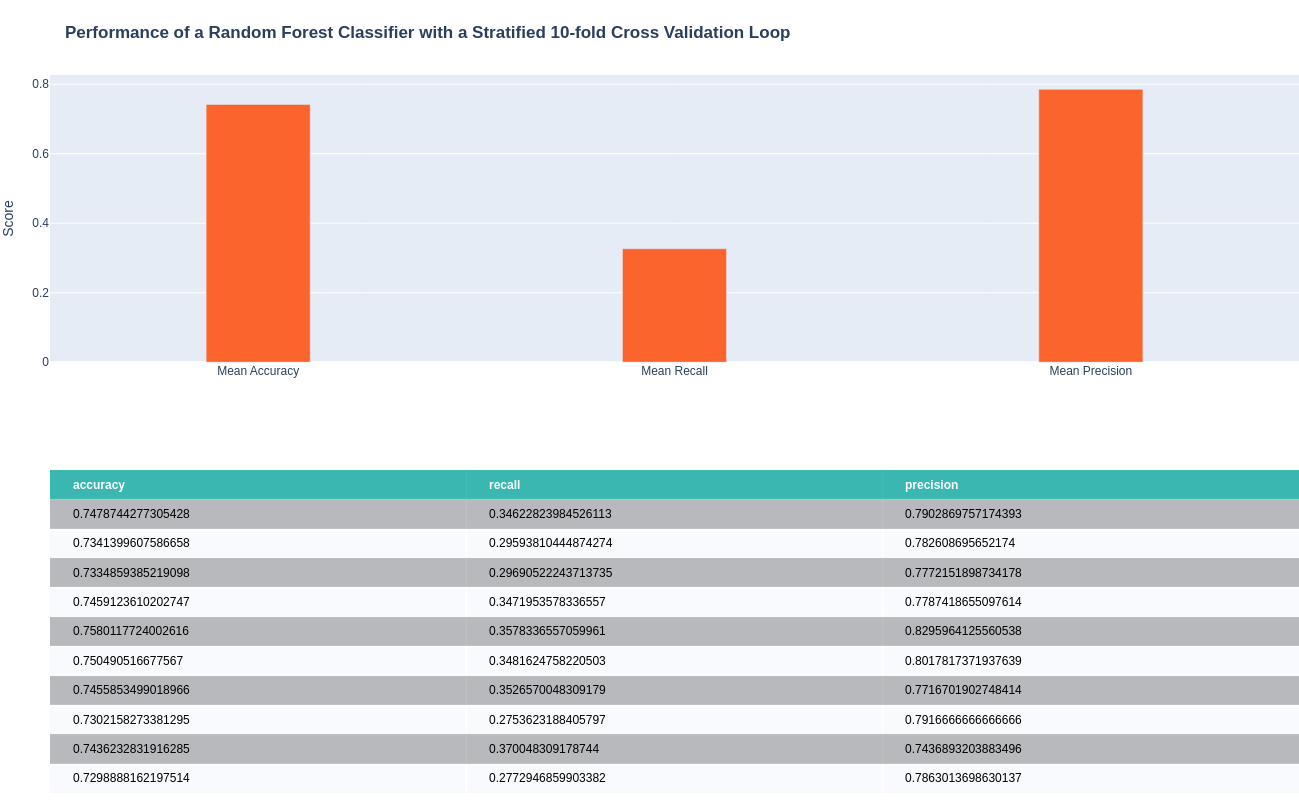

In [32]:
### random forest model with the stratified 10-fold cross validation loop
cellTitle = '<b>Performance of a Random Forest Classifier with a Stratified 10-fold Cross Validation Loop</b>'


# random forest takes in sparse matrices, so we will convert X into a matrix using scipy
X_mat = scipy.sparse.coo_matrix(X)
X_mat = X_mat.tocsr()

rfcScore = []
rf_clf = RandomForestClassifier(max_depth=10, random_state=1024,n_jobs=-1)
for train,test in skf.split(X_mat,y):
    rf_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = rf_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    rfcScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
rfcScore = pd.DataFrame(rfcScore)
#print(score)
#print('mean accuracy: ',score['accuracy'].mean(),
#     '\nmean sensitivity: ',score['recall'].mean(),
#     '\nmean precision: ',score['precision'].mean())

rfFig = plotMetrics(rfcScore, cellTitle)
rfFig.show()

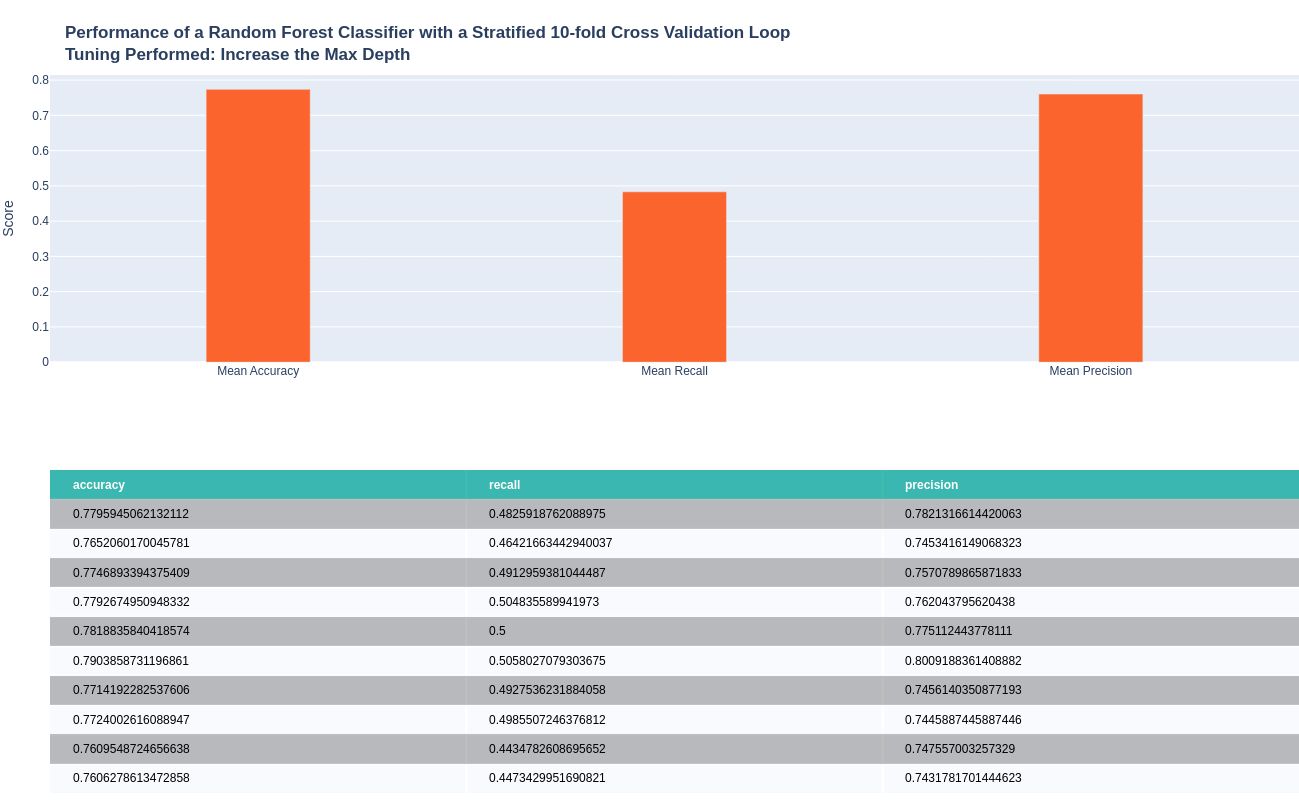

In [33]:
## repeat adjusting tuning parameters to achieve better results
# increasing max depth (largely increases complexity), 
cellTitle = '<b>Performance of a Random Forest Classifier with a Stratified 10-fold Cross Validation Loop<br>Tuning Performed: Increase the Max Depth</b>'
rfcScore = []
rf_clf = RandomForestClassifier(max_depth=15, random_state=1024, n_jobs=-1)
for train,test in skf.split(X_mat,y):
    rf_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = rf_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    rfcScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
rfcScore = pd.DataFrame(rfcScore)
rfFig = plotMetrics(rfcScore, cellTitle)
rfFig.show()

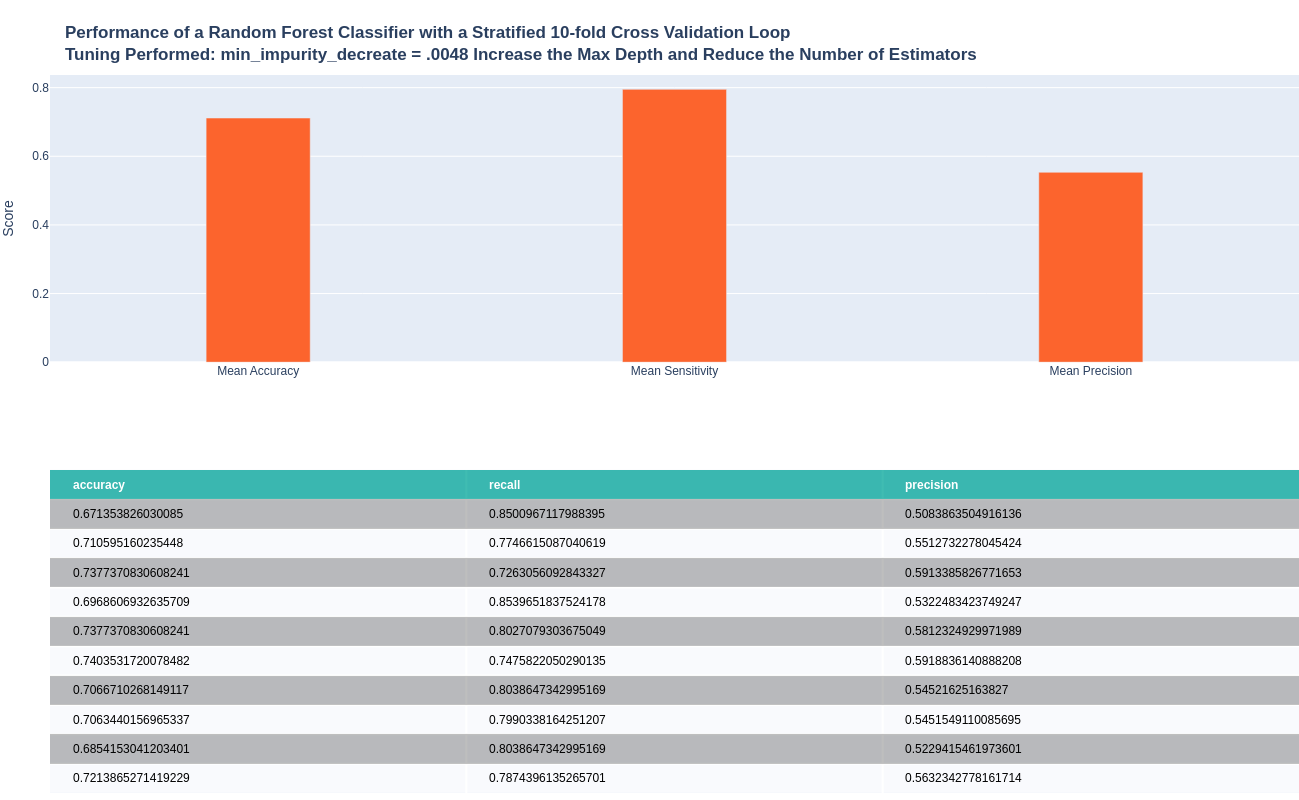

CPU times: user 4.86 s, sys: 415 ms, total: 5.28 s
Wall time: 1.56 s


In [40]:
%%time
start =time.time()
## increasing tree depth largely increases computational cost, so we will reduce the number of estimators to compensate and keep computing time reasonable
cellTitle = '<b>Performance of a Random Forest Classifier with a Stratified 10-fold Cross Validation Loop<br>Tuning Performed: min_impurity_decreate = .0048 Increase the Max Depth and Reduce the Number of Estimators</b>'
rfcScore = []
rf_clf = RandomForestClassifier(max_depth=150, n_estimators = 45,random_state=1024,n_jobs=-1, class_weight='balanced', min_impurity_decrease=.00048)
for train,test in skf.split(X_mat,y):
    rf_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = rf_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    rfcScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
rfcScore = pd.DataFrame(rfcScore)
rfFig = plotMetrics(rfcScore, cellTitle)
rfFig.show()
stop = time.time()
rfcTime = stop-start

#### NaiveBayes

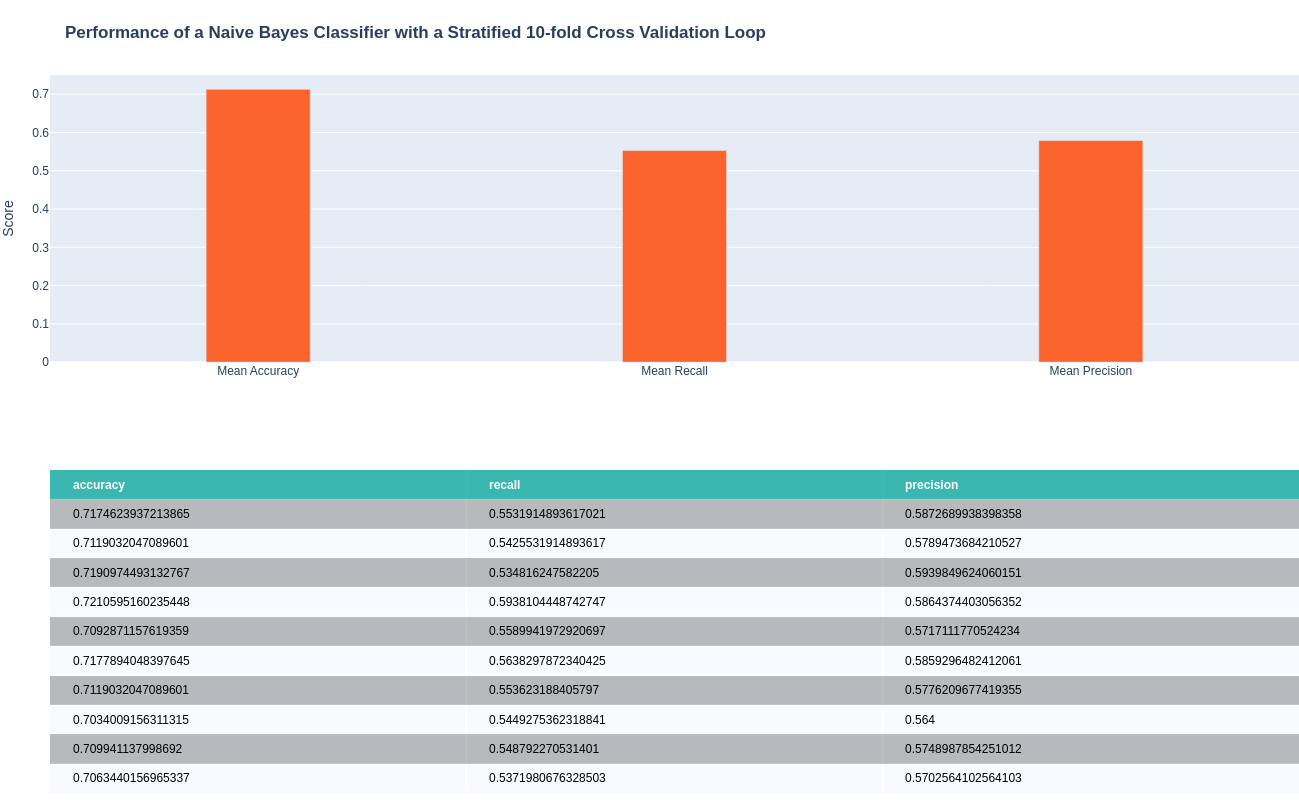

In [85]:

cellTitle = '<b>Performance of a Naive Bayes Classifier with a Stratified 10-fold Cross Validation Loop</b>'

from sklearn.naive_bayes import BernoulliNB
nb_clf = BernoulliNB()

nbScore = []
for train,test in skf.split(X_mat,y):
    nb_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = nb_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat,labels=[1,0])
    nbScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
nbScore = pd.DataFrame(nbScore)
nbFig = plotMetrics(nbScore, cellTitle)
nbFig.show()

In [86]:
### redoing NaiveBayes model

nbScore = []
for train,test in skf.split(X_mat,y):
    for i in [.001,.25,.5,.75,.85,1]:
        for j in [.001,.002,.003,.005,.01]:
            nb_clf = BernoulliNB(alpha=i,binarize=j,fit_prior=False)
            nb_clf.fit(X_mat[train],y.values.ravel()[train])
            y_hat = nb_clf.predict(X_mat[test])

            cm = confusion_matrix(y.loc[test],y_hat,labels=[1,0])
            nbScore.append({'alpha':i,'binarize':j,'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                    'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                    'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
nbScore = pd.DataFrame(nbScore)
nbScore.groupby(['alpha','binarize']).mean().nlargest(n=3,columns = ['recall'])

accuracy    recall  precision
alpha binarize                               
0.50  0.001     0.681818  0.766631   0.520141
0.75  0.002     0.681458  0.766631   0.519764
      0.003     0.681458  0.766631   0.519764

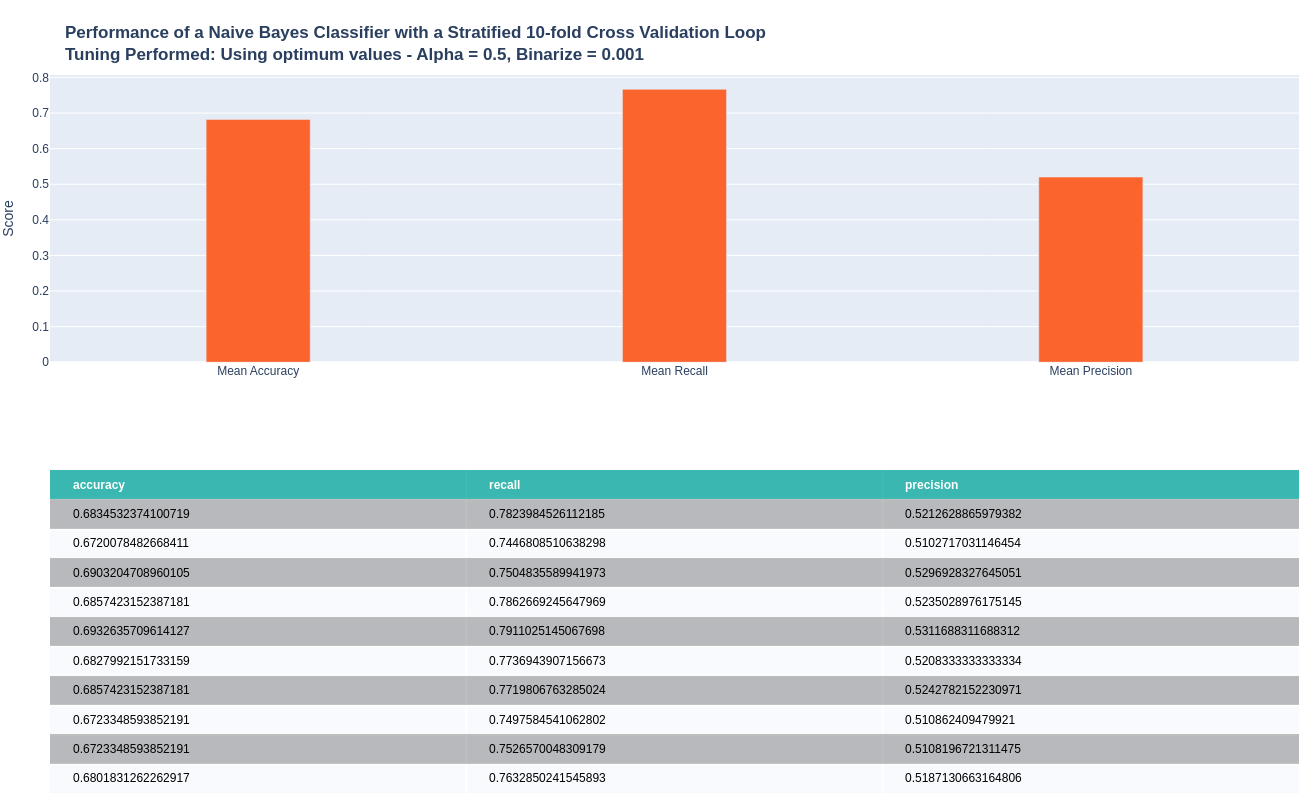

CPU times: total: 33.1 s
Wall time: 23.5 s


In [100]:
%%time
start = time.time()
# fit model with alpha .5 and binarize .001 as found prior
cellTitle = '<b>Performance of a Naive Bayes Classifier with a Stratified 10-fold Cross Validation Loop<br>Tuning Performed: Using optimum values - Alpha = 0.5, Binarize = 0.001</b>'
nbScore = []
nb_clf = BernoulliNB(alpha=.5,binarize=.001,fit_prior=False)
for train,test in skf.split(X_mat,y):
    nb_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = nb_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    nbScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
nbScore = pd.DataFrame(nbScore)
nbFig = plotMetrics(nbScore, cellTitle)
nbFig.show()
stop = time.time()
nbTime = stop-start


nbImps = permutation_importance(nb_clf, X_mat[test].toarray(), y.loc[test])
#print(imps.importances_mean)


#### SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


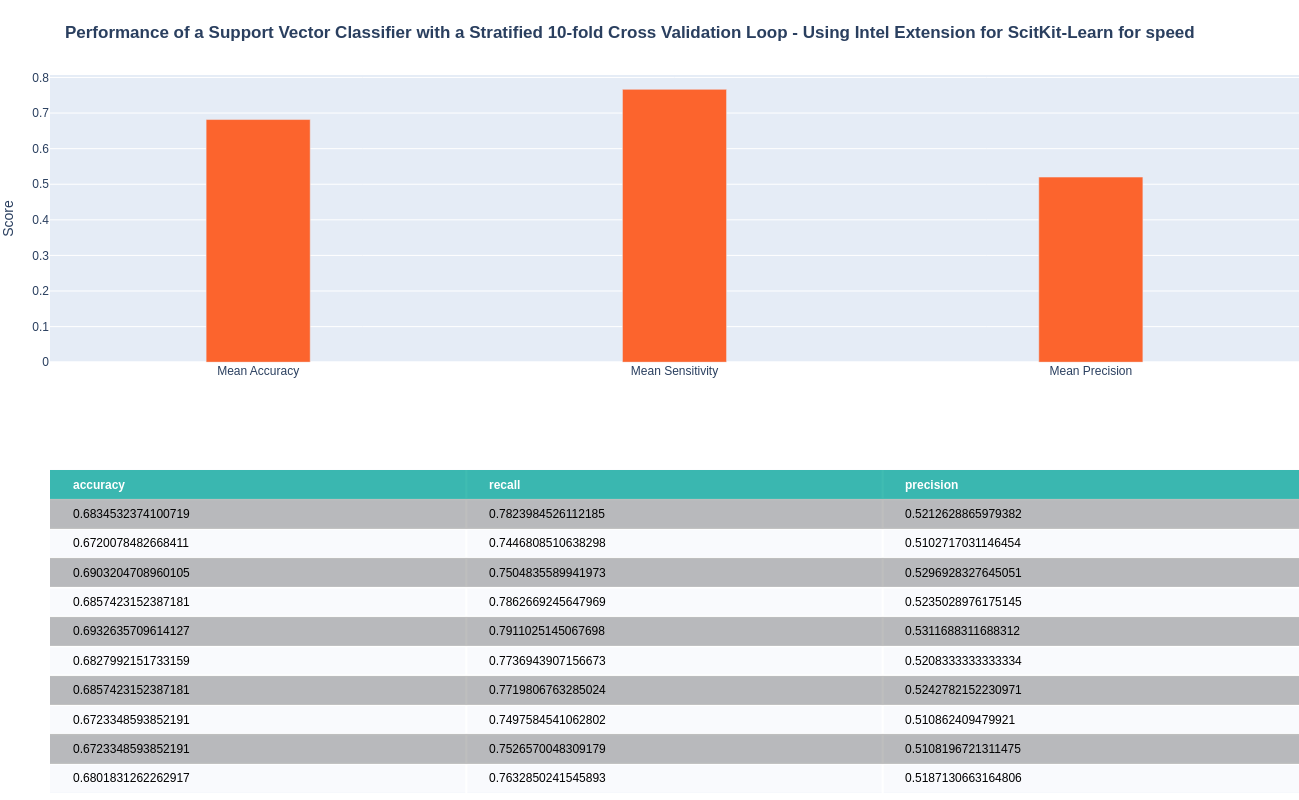

In [44]:
cellTitle = '<b>Performance of a Support Vector Classifier with a Stratified 10-fold Cross Validation Loop - Using Intel Extension for ScitKit-Learn for speed</b>'
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.svm import SVC

svmScore = []
svm_clf = SVC(kernel='rbf', gamma='auto')
for train,test in skf.split(X_mat,y):
    svm_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = svm_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    svmScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
svmScore = pd.DataFrame(svmScore)
svmFig = plotMetrics(nbScore, cellTitle)
svmFig.show()

In [30]:
%%time
start =time.time()
patch_sklearn()
cellTitle = '<b>Performance of a Support Vector Classifier with a Stratified 10-fold Cross Validation Loop - Using Intel Extension for ScitKit-Learn for speed<br>Tuning Performed: Adjusting cache size and class weights</b>'
from sklearn.svm import SVC
svmScore = []
svm_clf = SVC(kernel='rbf', gamma='auto', cache_size=800,class_weight={0:34, 1:66})
for train,test in skf.split(X_mat,y):
    svm_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = svm_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    svmScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
svmScore = pd.DataFrame(svmScore)
svmFig = plotMetrics(svmScore, cellTitle)
svmFig.show()
stop = time.time()
svmTime = stop-start


svmImps = permutation_importance(svm_clf, X_mat[test].toarray(), y.loc[test])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


CPU times: total: 31min 59s
Wall time: 8min 36s


In [46]:
unpatch_sklearn()

#### Logistic Regression

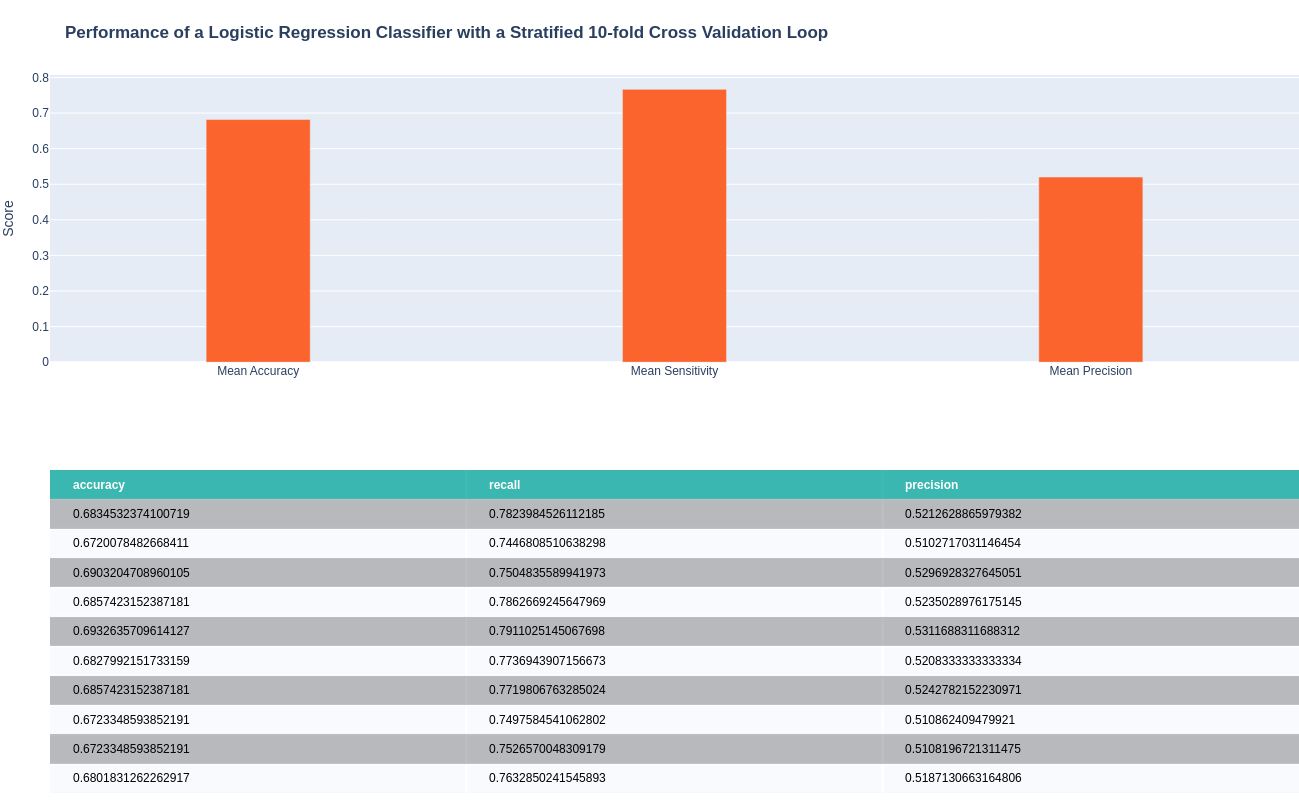

In [47]:
cellTitle = '<b>Performance of a Logistic Regression Classifier with a Stratified 10-fold Cross Validation Loop</b>'
from sklearn.linear_model import LogisticRegression

lor_clf = LogisticRegression(random_state=1024,max_iter=400)
lorScore = []
for train,test in skf.split(X_mat,y):
    lor_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = lor_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    lorScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
lorScore = pd.DataFrame(lorScore)
lorFig = plotMetrics(nbScore, cellTitle)
lorFig.show()

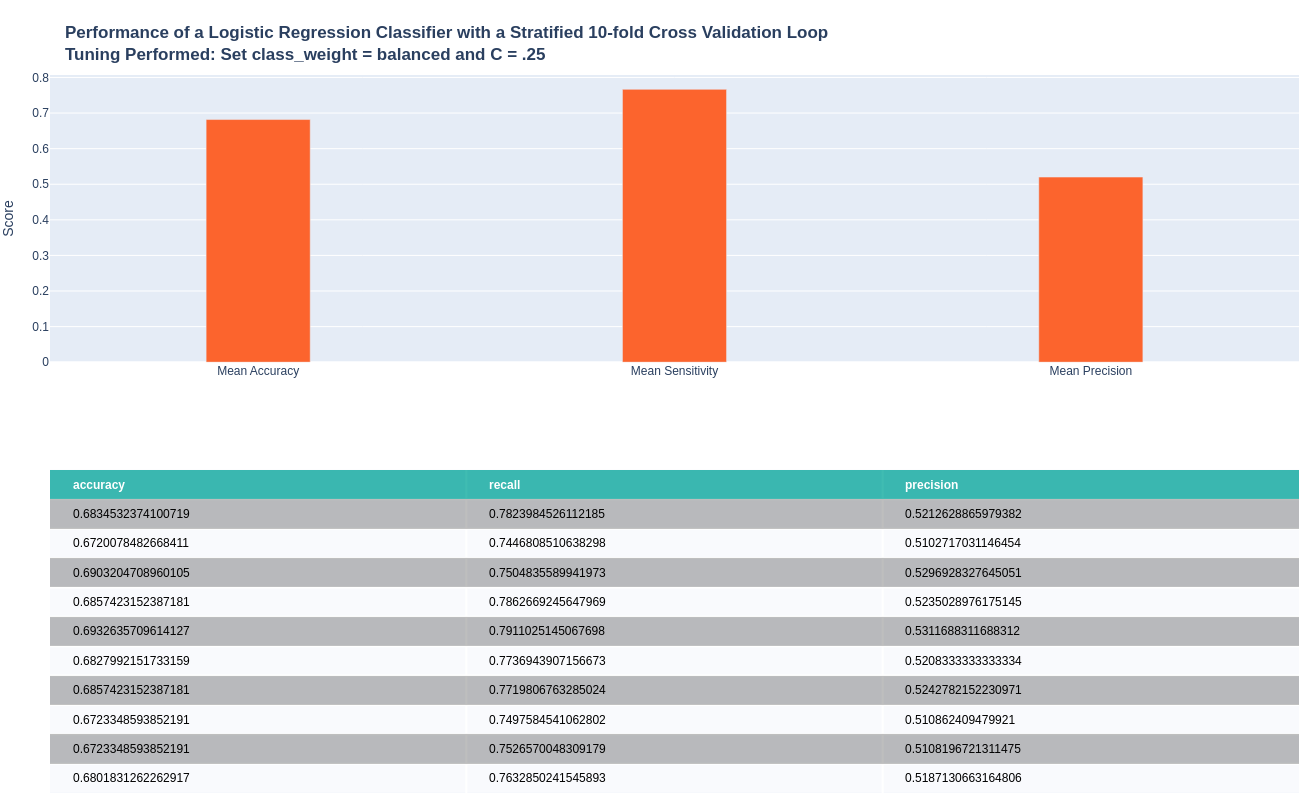

CPU times: user 3.38 s, sys: 23.8 ms, total: 3.4 s
Wall time: 3.4 s


In [48]:
%%time
start =time.time()
## refit logistic regression model with parameter tuning
cellTitle = '<b>Performance of a Logistic Regression Classifier with a Stratified 10-fold Cross Validation Loop<br>Tuning Performed: Set class_weight = balanced and C = .25</b>'

lor_clf = LogisticRegression(random_state=1024,max_iter=400,class_weight='balanced',C=.2)
lorScore = []
for train,test in skf.split(X_mat,y):
    lor_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = lor_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    lorScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
lorScore = pd.DataFrame(lorScore)
lorFig = plotMetrics(nbScore, cellTitle)
lorFig.show()
stop = time.time()
lorTime = stop-start

#### KNN

KNN Classifier - From sklearn.neighbors, we use the KNeighborsClassifier.  

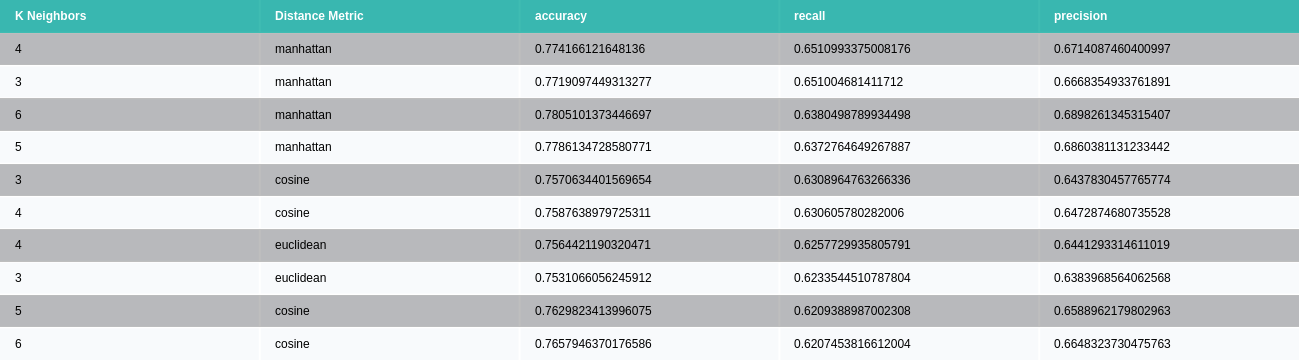

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

knnScore = []

for train,test in skf.split(X_mat,y):
    for i in range(3,7):
        for j in ['manhattan','euclidean','cosine']: #'manhattan','euclidean','cosine'
            knn_clf = KNeighborsClassifier(n_neighbors=i,metric=j,n_jobs=-1, weights='distance')
            knn_clf.fit(X_mat[train],y.values.ravel()[train])
            y_hat = knn_clf.predict(X_mat[test])

            cm = confusion_matrix(y.loc[test],y_hat,labels=[1,0])
            knnScore.append({'K Neighbors':i,'Distance Metric':j,'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                    'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                    'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
knnScore = pd.DataFrame(knnScore)
meanScores = knnScore.groupby(['K Neighbors','Distance Metric']).mean().nlargest(n=10,columns = ['recall']).reset_index()
fig2 = ff.create_table(meanScores, height_constant=20, colorscale=[[0, '#00A699'], [.5, '#a9a9a9'], [1, '#ffffff']])


fig2.show()


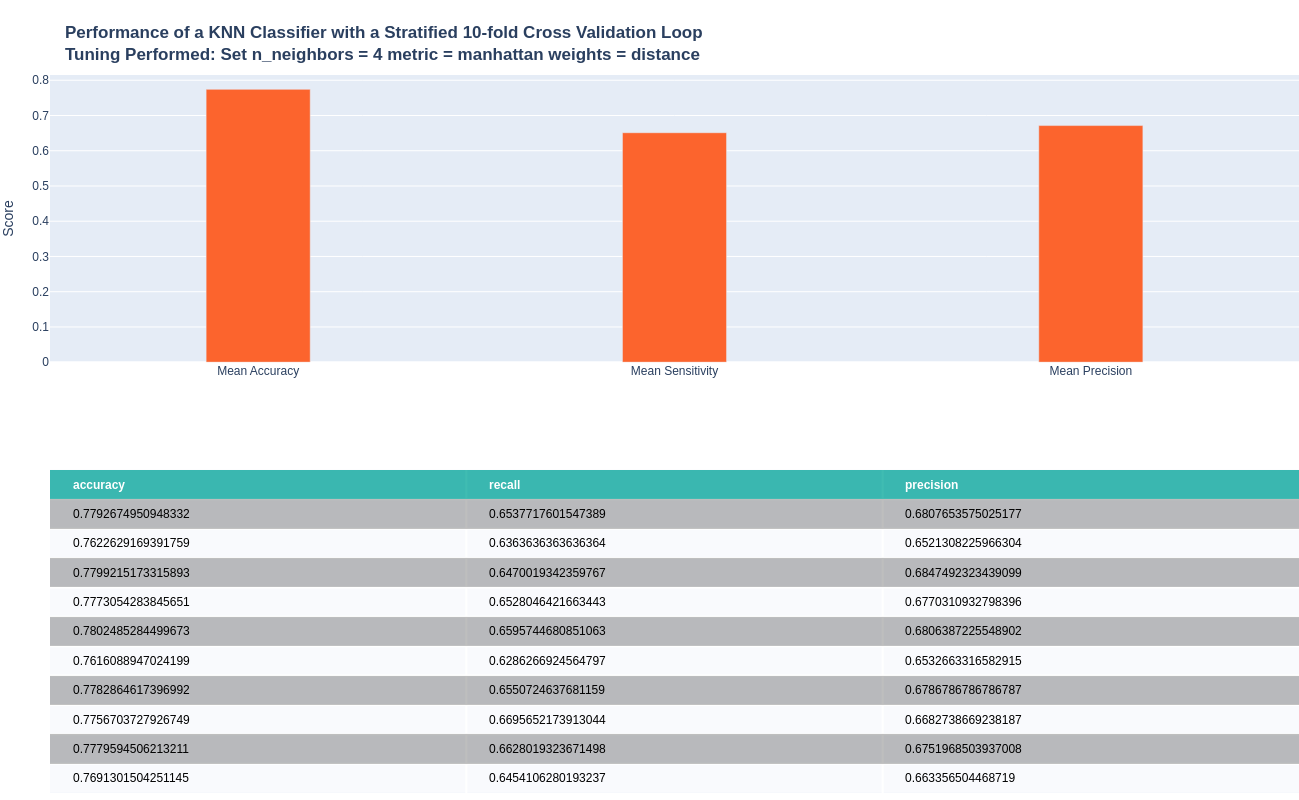

CPU times: user 1min 14s, sys: 7.05 s, total: 1min 21s
Wall time: 16.9 s


In [50]:
%%time
start = time.time()
cellTitle = '<b>Performance of a KNN Classifier with a Stratified 10-fold Cross Validation Loop<br>Tuning Performed: Set n_neighbors = 4 metric = manhattan weights = distance</b>'
knn_clf = KNeighborsClassifier(n_neighbors=4, metric='manhattan',n_jobs=-1, weights='distance')
knnScore = []

for train, test in skf.split(X_mat,y):
    knn_clf.fit(X_mat[train],y.values.ravel()[train])
    y_hat = knn_clf.predict(X_mat[test])
    
    cm = confusion_matrix(y.loc[test],y_hat, labels=[1,0])
    knnScore.append({'accuracy':(cm[0,0]+cm[1,1])/sum(cm.ravel()),
                'recall':cm[0,0]/(cm[0,0]+cm[0,1]),
                'precision':cm[0,0]/(cm[0,0]+cm[1,0])})
knnScore = pd.DataFrame(knnScore)
knnFig = plotMetrics(knnScore, cellTitle)
knnFig.show()
stop =time.time()
knnTime=stop-start

## Modeling and Evaluation 4
Rubric (10 pts): Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

In [51]:
# NEED TO ADD 

### Task 1

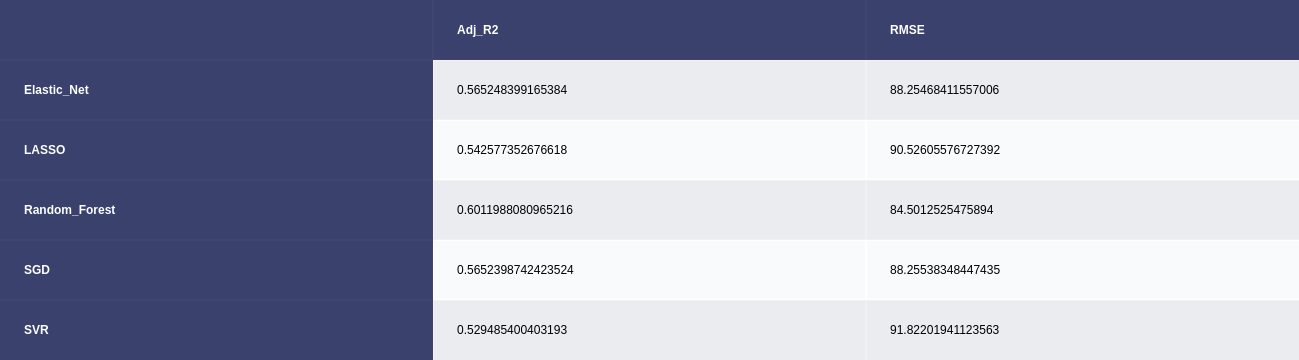

In [52]:
regEval = pd.concat([enScore.assign(model='Elastic_Net'),
           lassoScore.assign(model='LASSO'),
           rfScore.assign(model='Random_Forest'),
           svrScore.assign(model='SVR'),
           sgdScore.assign(model='SGD')])
regFig=ff.create_table(regEval.groupby('model').mean(),index=True)
regFig.show()

For task 1, we fitted models using 5 different regression algorithms. This table shows the average performance of the best performing model for each algorithm over the iterations of the cross validation. For RMSE, a smaller value means predictions were on average, closer to the true value of the response variable, so a smaller error is desirable. When comparing the Root Mean Squre Error, we can see that the Random Forest model performed better than the rest. Since RMSE is in the same scale as our response variable (price), we can see that on average, random forest performed better than the other models by a margin of a few dollars.
We calculated the Adjusted r squared error, as a secondary error metric. On this case, the random forest model also performed better the other models (a higher r squared value)

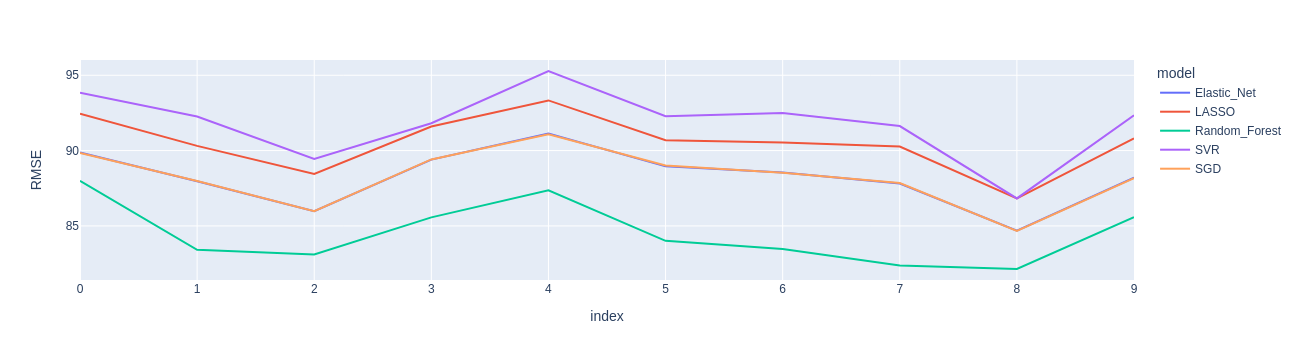

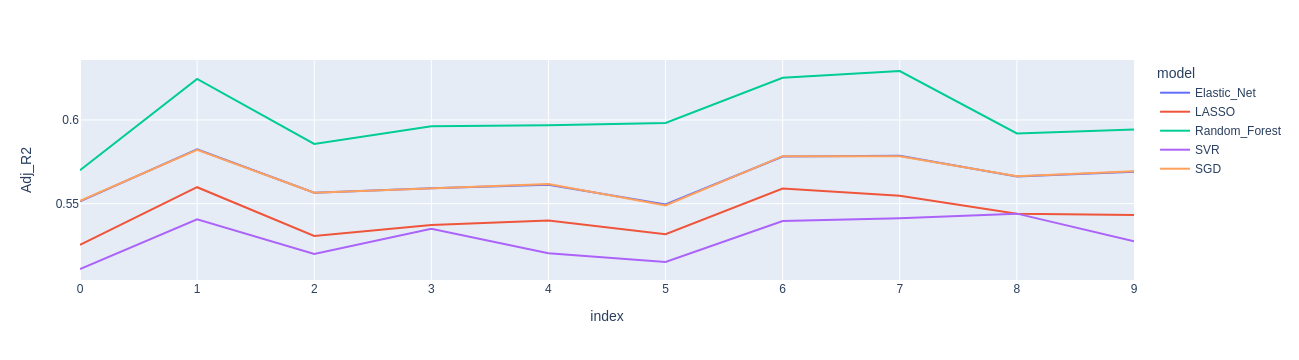

In [53]:
regFig2 = px.line(regEval, x=regEval.index, y = 'RMSE', color = 'model')
regFig3 = px.line(regEval, x = regEval.index, y='Adj_R2', color ='model')
regFig2.show()
regFig3.show()

The top plot shows the Root Mean Square Error of the best model for each algorithim, over the 10 iterations of the cross validation (one iteration for each fold). From the plot, we can clearly see that Random forest performed better than the other models over each iteration, with a visible gap between random forest and the other models.
We can also see that for adjusted r squared, there is noticeable, consistent serparation between random forest and the other models, with random forest showing a larger adjusted r squared than the rest.

The usefuleness of this plot is that it can show if a lower or higher average are the result of the model consistently performing better than the rest, or the result of a single (or a few) iteration having a significantly larger (or smaller) value bringing the whole average up significantly. The mean is not resistant to outliers, so this plot can serve as visual evidence of a model's consistency of performance. 

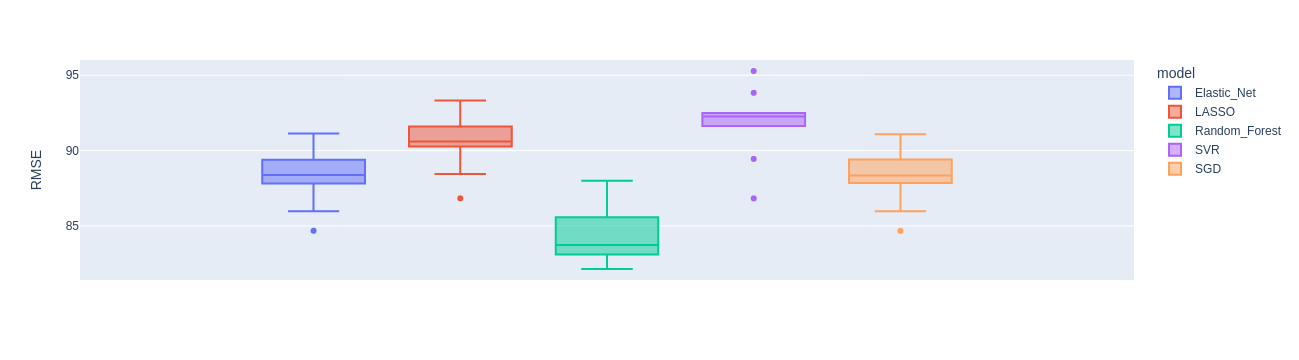

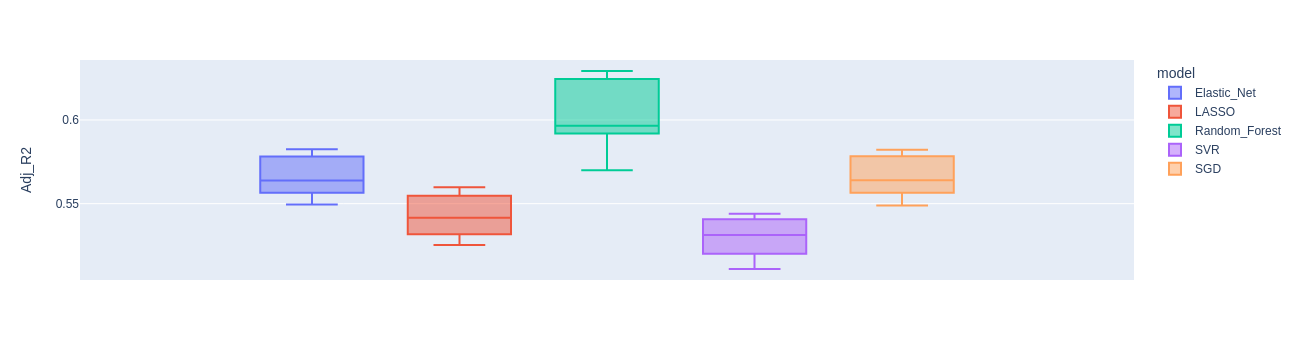

In [54]:
regFig4 = px.box(regEval, y= 'RMSE', color = 'model')
regFig5 = px.box(regEval, y='Adj_R2', color = 'model')
regFig4.show()
regFig5.show()

These boxplots show the distribution of RMSE and mean adjusted r squared for the 10 iterations of the 10-fold cross validation. The inner box represent the distribution from the 25 percentile to the 75 percentile (the inner 50%). Although there is some overlap on the tails, we can clearly see that Random forest is below all other models for RMSE, meaning it produces predictions with a smaller error from the true value.In terms of RMSE, there is more noticeable overlap for the other 4 models, while Random Forest is clearly below the rest, with it's interquartile range (IQR, the range from 25 percentile to the 75 percentile) showing no overlap with other boxplots.
In terms of their adjusted R squared, we see a similar pattern, where the random forest IQR distribution is clearly separated from the other 4 models, while the other models have a larger degree of overlap between their IQR.

### Task 2

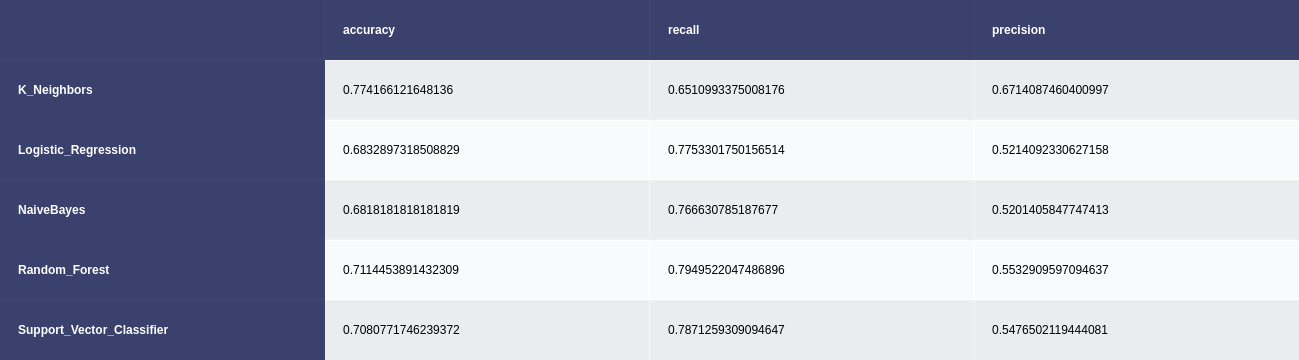

In [55]:
clfEval = pd.concat([rfcScore.assign(model='Random_Forest'),
                    nbScore.assign(model='NaiveBayes'),
                    svmScore.assign(model='Support_Vector_Classifier'),
                    lorScore.assign(model='Logistic_Regression'),
                    knnScore.assign(model='K_Neighbors')])
clfFig=ff.create_table(clfEval.groupby('model').mean(),index=True)
clfFig.show()

This table shows the average accuracy, recall, and precision of our 5 models. For this task, we focused on producing models with high recall for predictions, so our main metric for comparison is the recall (or sensitivity). From the table, we can see that 4 of the models have very similar performances, in the 77.5-79.5 range. With KNN (K Neighbors) having noticeably lower recall than the rest. Random forest has the overall highest recall out of the 5 models, while also having the highest overall mean accuracy out of the 4 models with comparable recall values. 

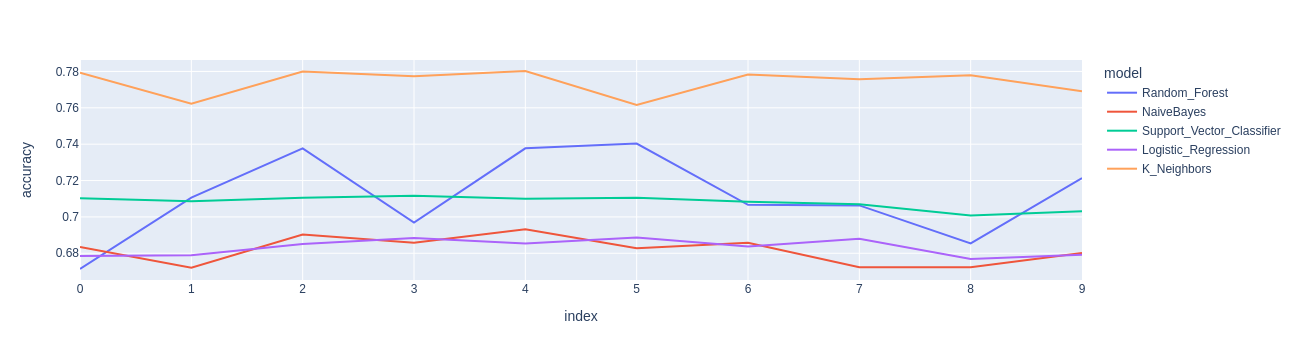

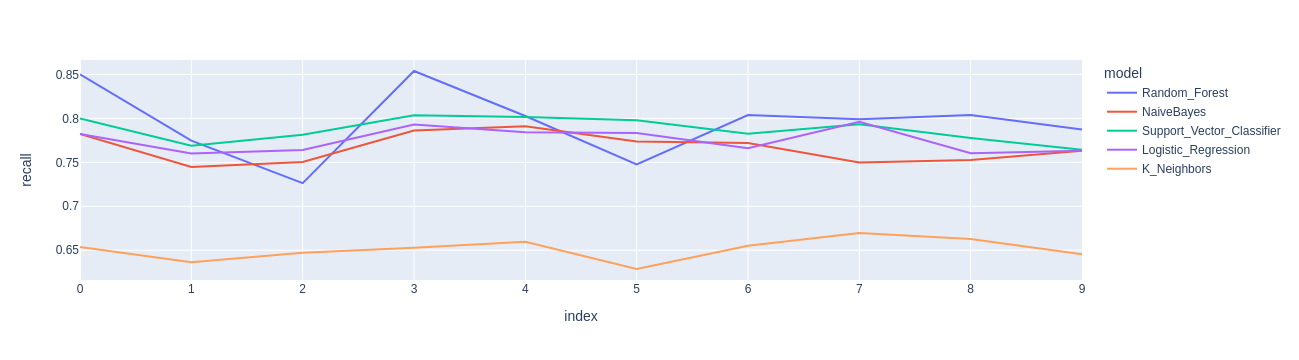

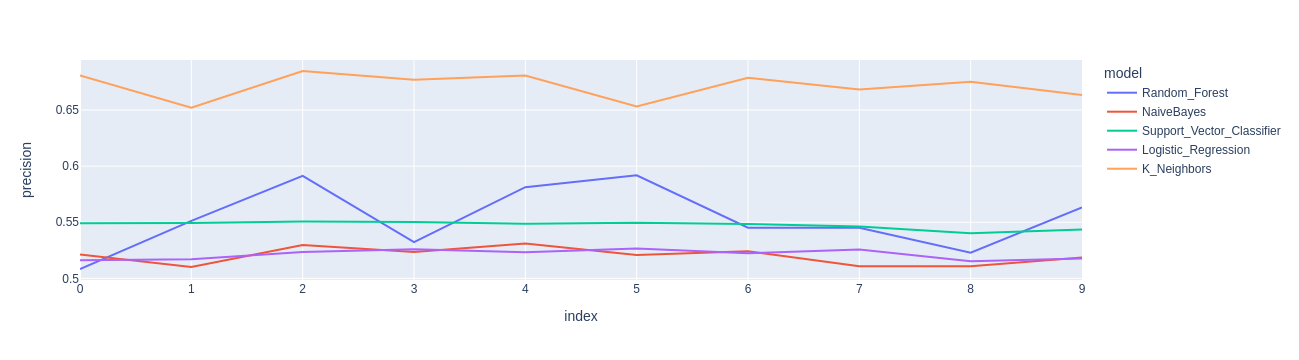

In [56]:
clfFig2 = px.line(clfEval, x = clfEval.index, y='accuracy', color= 'model')
clfFig3 = px.line(clfEval, x = clfEval.index, y ='recall', color = 'model')
clfFig4 = px.line(clfEval, x = clfEval.index, y ='precision', color = 'model')
clfFig2.show()
clfFig3.show()
clfFig4.show()

This plot shows the model's performance in terms of the accuracy, recall and precision. Our main focus here is on the recall metric, where we can see that although random forest had slightly higher average recall, the model did not consistently perform better than the rest over the 10 iterations of the cross validation. In fact, on some iterations, it performed worse than 3 of the other models. This is not entirely unexpected, since the top 4 models had similar performance in terms of recall, however, it should be noted that the Support Vector Classifier (SVC) had the most consistent performance over the 10 iterations.
Another thing of note is that, while KNN had the highest accuracy, it performed consistently worse than the other 4 models in terms of recall, our main performance metric. The overall high accuracy is influenced by the fact that the KNN model clearly outperforms the other models in terms of precision.

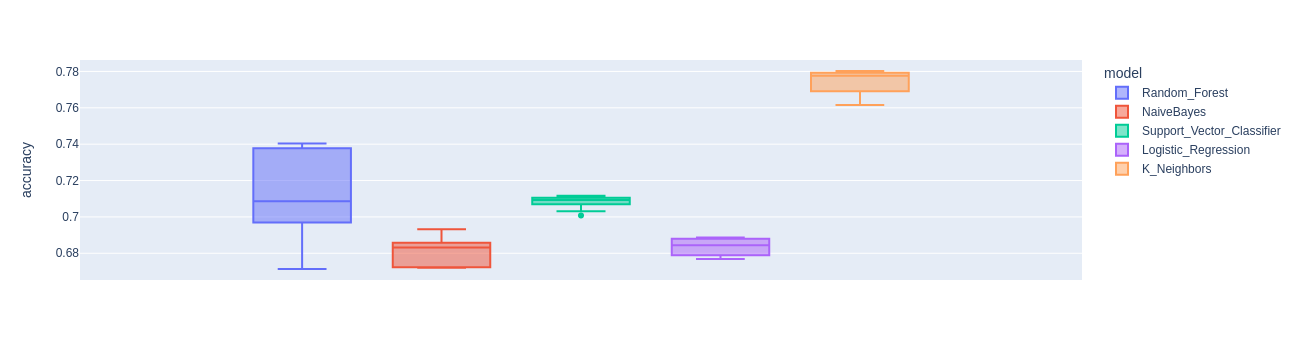

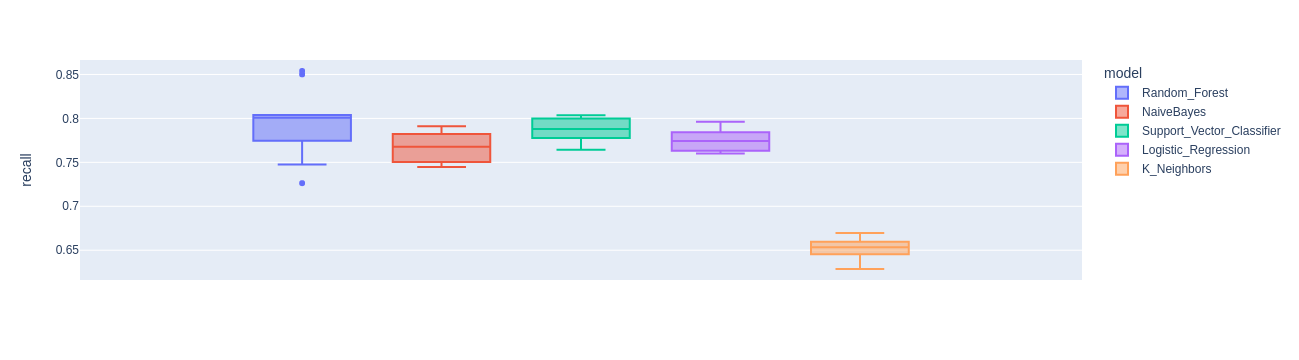

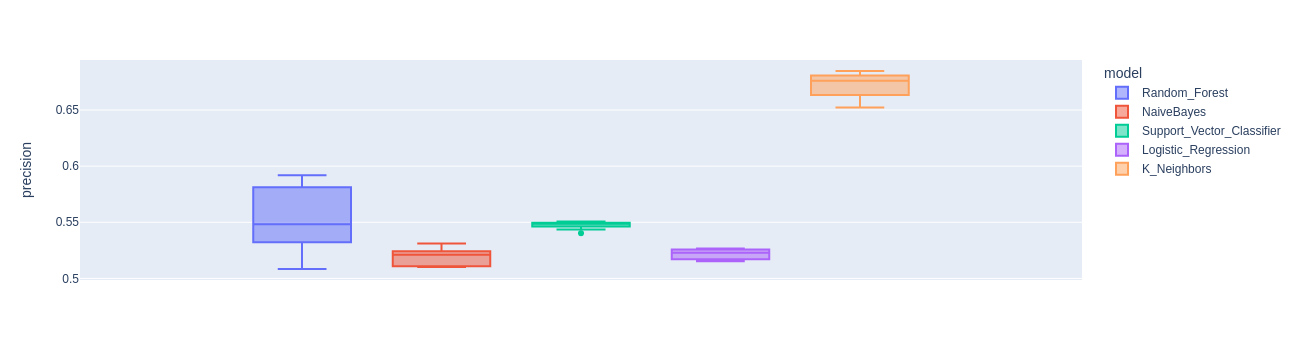

In [57]:
clfFig5 = px.box(clfEval, y='accuracy',color='model')
clfFig6 = px.box(clfEval, y='recall',color='model')
clfFig7 = px.box(clfEval, y='precision',color='model')
clfFig5.show()
clfFig6.show()
clfFig7.show()

These boxplots show the distribution of accuracy, recall, and precision for each of our 5 models. Focusing on our desired metric, recall, we can see that there is significant overlap between our top 4 performing models, with KNN having significantly worse performance, and a clear separtaion (with no overlap) with the other models.
While random forest had a slightly higher average recall, we can see from its boxplot that it also had the widest distribution out of our top 4 models. Meaning there was more variation in the recall over the 10 iterations, than for the other top 4 models. It should be noted that SVC had the narrowest  

## Modeling and Evaluation 5
Rubric (10 pts): Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

### Task 1:
For the regression task, our goal was to find a model that could predict listing price for Los Angeles AirBnB properties. Our goal was to find a model that could predict listing price with a low Root Mean Square error.

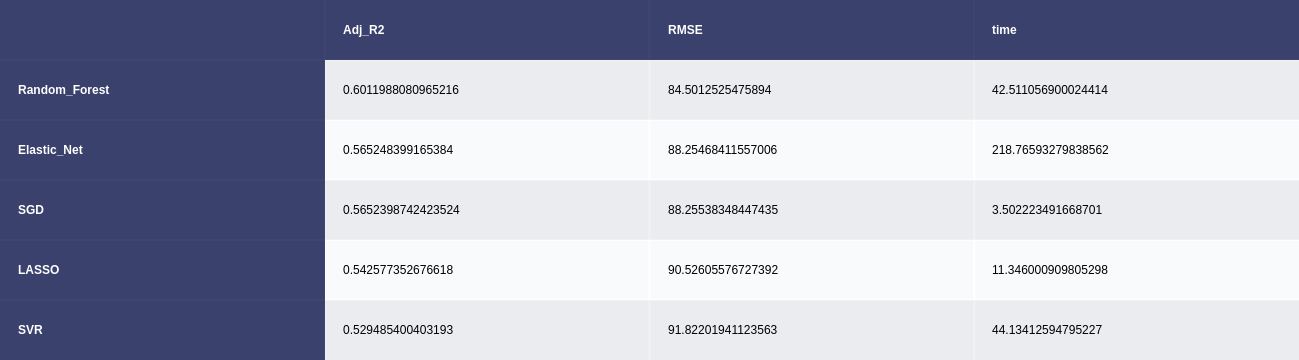

In [58]:
regEval2 = regEval.groupby('model').mean()
regEval2['time']=[enTime,lassoTime,rfTime,sgdTime,svrTime]
regFig6 = ff.create_table(regEval2.sort_values(by='RMSE'),index=True)
regFig6.show()

Our top performing models in terms of their average RMSE were random Forest and Elastic Net. However, Random Forest performed marginally better in terms of the error, while taking 1/5 of the time that it took Elastic Net to fit the model and produce the predictions.
In fact, Stochastic Gradient Descent regressor produced practically the same results in terms of RMSE (and adjust r squared), while taking less than 5 seconds (as opposed to Elastic Net which took over 220 seconds). In terms of computational time, SGD outperforms all other models, while producing results in line with Elastic Net, and better error metrics than Lasso and Support Vector Regression.
Elastic Net was by far the slowest of all 5 of our regression models, so despite producing comparable error results, it is outperformed by random forest in both prediction error and computation time.

# Was planning on setting up a table with 'advantages', no longer convinced it's the best idea
model | advantages
---|---
Elastic Net | 
Lasso | best for
Random Forest | The main advantage of this model is how quickly it runs, once the model has been fitted with the tuned parameters, this model can run very quickly while still producing results with high recall
SVR | best for
SGD |


### T-test

In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv
t_reg, p_reg = paired_ttest_5x2cv(estimator1=rf_reg,estimator2=en_reg,X=X_reg,y=y_reg.values.ravel(),random_seed=1024, scoring = 'neg_root_mean_squared_error')
print(t)
print(p)

We ran a comparison of the top 2 models, to see if there's a statistical significant difference between the two. This test results in a p-value less than .05, meaning there's evidence at the .05 level of significance, that the errors are 

### Task 2
prof. mentioned the easiest thing to do was to get AUC and compare these, since AUC has statistical value attached, however AUC is not only dependent on recall

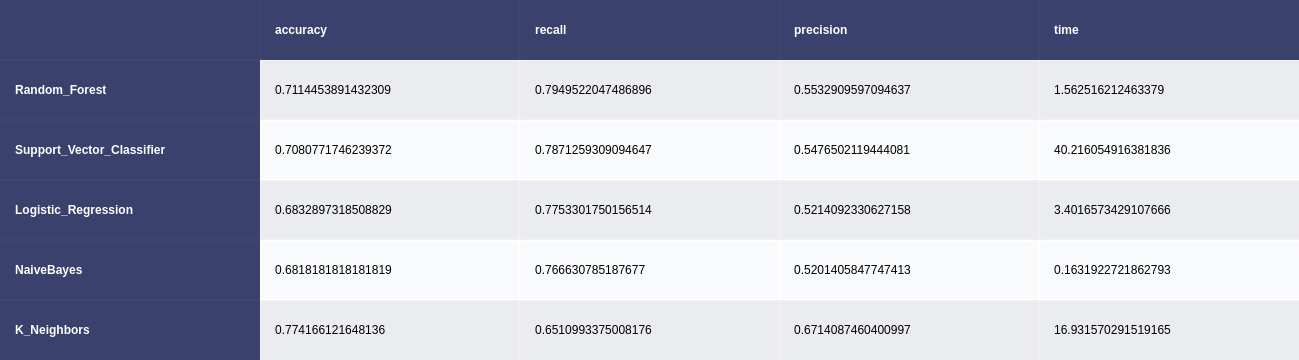

In [59]:
clfEval2 = clfEval.groupby('model').mean()
clfEval2['time']=[knnTime,lorTime,nbTime,rfcTime,svmTime]
clfFig8 = ff.create_table(clfEval2.sort_values(by='recall',ascending=False),index=True)
clfFig8.show()

We can see from the table that 4 out of the 5 models performed similarly in terms of their average recall (their ability to correctly predict a host is superhost when in fact they are superhost). However, there is a large variation in terms of their computational times, with Support Vector Classifier (SVC) being the most computationally expensive at 40.2 seconds.
Random Forest had the highest recall at .795, as while also having the second shortest time at 1.7 seconds.
Our KNN model performed significantly worse in terms of recall, however, it should be noted that this model performed best in terms of overall accuracy.

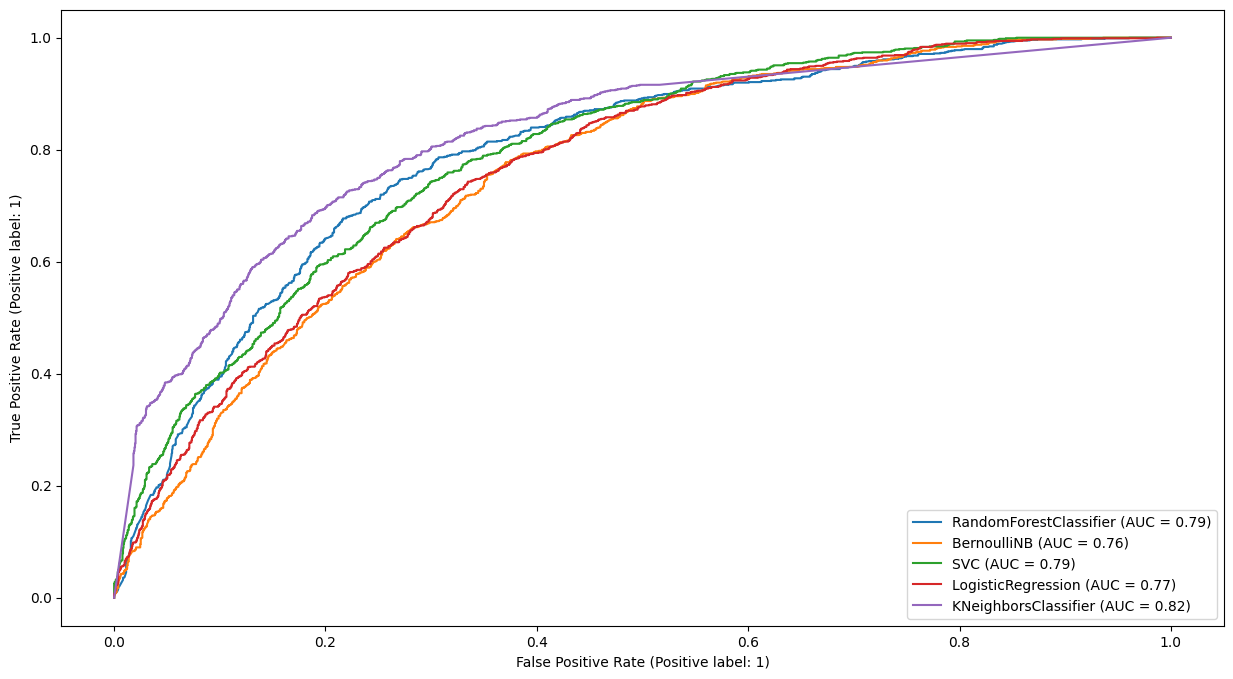

In [60]:
# ROC random forest, for the final product, we could plot all ROC curves under a single plot, leaving this in for now
import matplotlib.pyplot as plt
from sklearn import metrics
ax = plt.figure(figsize=(15,8)).gca()
rfc_disp = metrics.RocCurveDisplay.from_estimator(rf_clf,X_mat[test],y.loc[test],pos_label=1,ax=ax)
nb_disp = metrics.RocCurveDisplay.from_estimator(nb_clf,X_mat[test],y.loc[test],pos_label=1,ax=ax)
svm_disp = metrics.RocCurveDisplay.from_estimator(svm_clf,X_mat[test],y.loc[test],pos_label=1,ax=ax)
lor_disp = metrics.RocCurveDisplay.from_estimator(lor_clf,X_mat[test],y.loc[test],pos_label=1,ax=ax)
knn_disp = metrics.RocCurveDisplay.from_estimator(knn_clf,X_mat[test],y.loc[test],pos_label=1,ax=ax)

Our main goal for task 2, was to find models that produced results with high recall, since we want the model to predict superhost when the superhost status should be expected (a higher rate of true positives). While the Area Under the Curve (AUC) is not a direct represantion of a model's recall performance, however, the area under the curve is a general representation of a model's ability to predict superhost status correctly. The y-axis of the ROC plot (the true positive rate) is equal to the recall (or sensitivity) of the model. This plot visually represents the balance between how well the model predicts superhost appropriately vs its inacurate superhost predictions.
Based on this plot, KNN has the best overall performance, with clear separation from the other models towards the top left corner of the plot. The closer the line is to the top right corner, the closer the AUC is to 1.
This plot also shows that Random Forest and SVC have similar performance, with equal AUC of .79. However, as previously stated, Random Forest had the overall best average recall, with significantly faster computing time than both SVC and KNN.

## Modeling and Evaluation 6
Rubric (10 pts): Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

In [32]:
def plotFeatureImportance(modelFI, X, typeOfModel):
    features = pd.Series(modelFI)
    features.sort_values(ascending=False, inplace=True)
    featureImportance = np.array(features.head(10))
    
    featureNames = np.array(X.columns.tolist())
    sortIndices = np.argsort(featureImportance)[::-1]
    fig = px.bar(x=featureImportance[sortIndices], y=featureNames[sortIndices], title = 'Top 10 Feature Importance of ' + typeOfModel)
    fig.update_traces(marker_color='#00A699')
    return fig
    

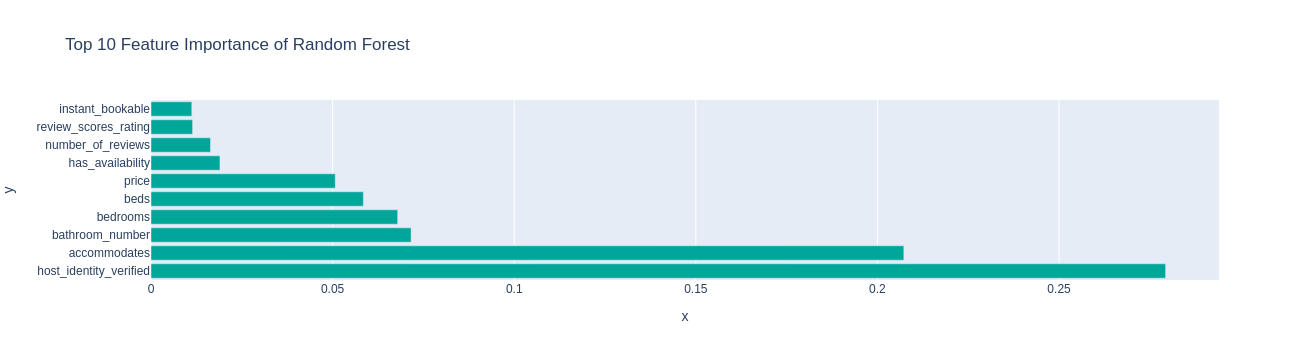

In [102]:
#Feature Importance of Classifiers

#Random Forest
rfFig_FI = plotFeatureImportance(rf_clf.feature_importances_, X, "Random Forest")
rfFig_FI.show()

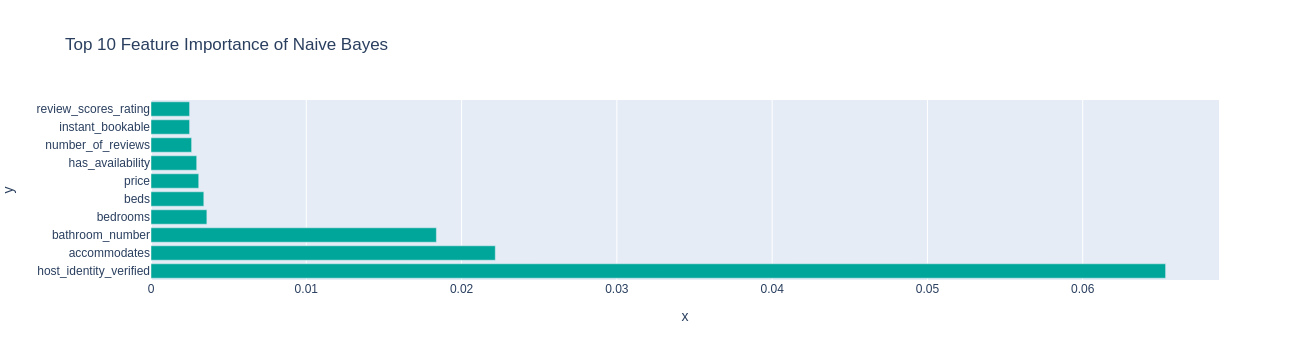

In [105]:
#Naive Bayes
#print(nbImps)

nbFig_FI = plotFeatureImportance(nbImps.importances_mean, X, "Naive Bayes")
nbFig_FI.show()

In [33]:
#SVM Classifier
svmFig_FI = plotFeatureImportance(svmImps.importances_mean, X, "Naive Bayes")
svmFig_FI.show()

## Deployment
Rubric (5 pts): How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Exceptional Work
Rubric (10 pts): You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?


In [61]:
### thinking of doing 5 models instead of 3